<a href="https://colab.research.google.com/github/M4mbo/Generative-Colourization-Approaches-to-CIFAR10/blob/main/CIFAR10_AE_GS2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torch.utils.data.sampler import SubsetRandomSampler
from mpl_toolkits.axes_grid1 import ImageGrid
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [128]:
def cifar10(batch_sz, random_seed, valid_size=0.2, shuffle=True):

  if random_seed is not None:
    torch.manual_seed(random_seed)

  transform_train = transforms.Compose([
      transforms.ToTensor(),
  ])
  transform_valid = transforms.ToTensor()
  transform_test = transforms.ToTensor()

  train_dataset = CIFAR10(root='./datasets', train=True, download=True, transform=transform_train)
  valid_dataset = CIFAR10(root='./datasets', train=True, download=True, transform=transform_valid)

  num_train = len(train_dataset)
  indices = list(range(num_train))
  split = int(np.floor(valid_size * num_train))
  if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
  train_idx, valid_idx = indices[split:], indices[:split]

  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_sz, sampler=train_sampler, pin_memory=True)
  valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_sz, sampler=valid_sampler, pin_memory=True)

  test_dataset = CIFAR10(root='./datasets', train=False, download=True, transform=transform_test)
  test_loader = DataLoader(test_dataset, batch_size=batch_sz)

  return train_loader, valid_loader, test_loader


In [129]:
def convert_to_grayscale(batch):

  grayscale_dataset = []
  for image in batch:
    # Convert colored image to grayscale by taking the average of all channels
    grayscale_image = torch.mean(image, dim=0, keepdim=True)
    grayscale_dataset.append((grayscale_image))

  grayscale_dataset = torch.stack(grayscale_dataset, dim=0)
  return grayscale_dataset


In [137]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data
random_seed=10
train_loader, valid_loader, test_loader = cifar10(batch_sz, random_seed)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [115]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [116]:
def visualize_dataset(dataloader):
  batch = next(iter(dataloader))
  images = batch[0]
  labels = batch[1]
  plt.figure(figsize=(15,15))
  for i in range(32):
    plt.subplot(8,8,i+1)
    img = np.transpose(images[i].numpy(), (1, 2, 0))  # Transpose the image dimensions
    plt.imshow(img)
    plt.title(classes[labels[i]])
    plt.axis("off")

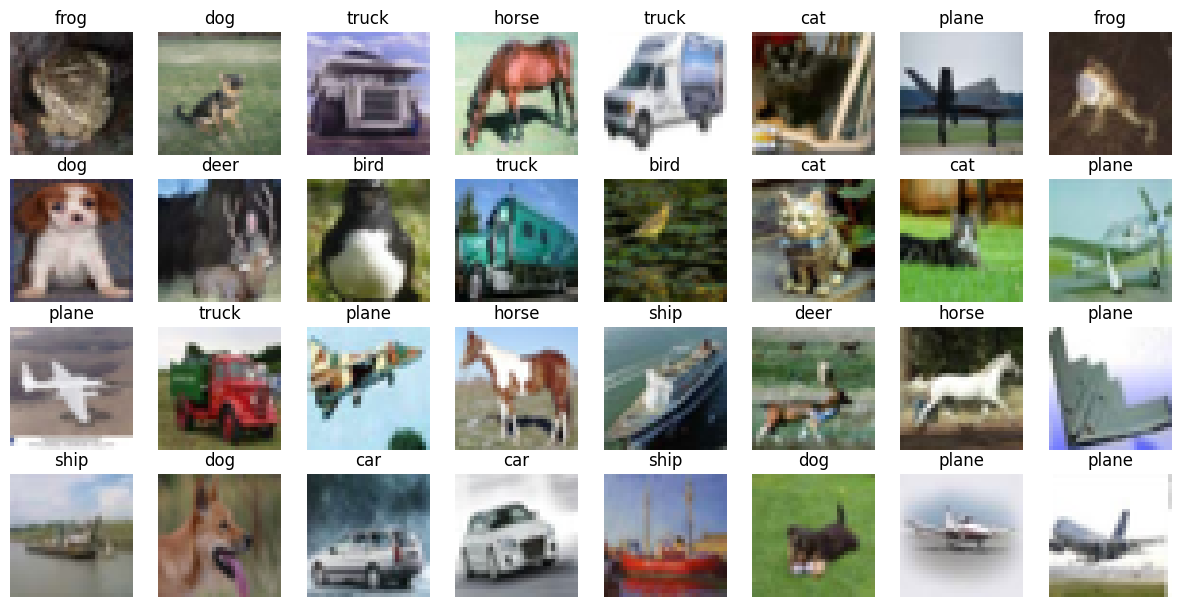

In [117]:
visualize_dataset(train_loader)

In [118]:
class AE(nn.Module):
  def __init__(self):
    super().__init__()
    # U-Net architecture

    self.encoding_unit1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
    )

    self.encoding_unit2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),
    )

    self.encoding_unit3 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(),
    )

    self.encoding_unit4 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(),
    )

    self.encoding_unit5 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(),
    )

    self.decoding_unit1 = nn.Sequential(
        nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(),
    )

    self.decoding_unit2 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(),
    )

    self.decoding_unit3 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),
    )

    self.decoding_unit4 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
    )
    self.decoding_unit5 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=3, kernel_size=1, stride=1, padding=0),
    )

    self.upsampling1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.upsampling2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.upsampling3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.upsampling4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)

  def encoder(self, x):

    x1 = self.encoding_unit1(x)
    x = F.max_pool2d(x1, (2,2))

    x2 = self.encoding_unit2(x)
    x = F.max_pool2d(x2, (2,2))

    x3 = self.encoding_unit3(x)
    x = F.max_pool2d(x3, (2,2))

    x4 = self.encoding_unit4(x)
    x = F.max_pool2d(x4, (2,2))

    x = self.encoding_unit5(x)

    return x, x1, x2, x3, x4

  def decoder(self, x, x1, x2, x3, x4):

    x = self.upsampling1(x)
    x = torch.cat([x, x4], dim=1)
    x = self.decoding_unit1(x)

    x = self.upsampling2(x)
    x = torch.cat([x, x3], dim=1)
    x = self.decoding_unit2(x)

    x = self.upsampling3(x)
    x = torch.cat([x, x2], dim=1)
    x = self.decoding_unit3(x)

    x = self.upsampling4(x)
    x = torch.cat([x, x1], dim=1)
    x = self.decoding_unit4(x)

    x = self.decoding_unit5(x)

    return x

  def forward(self, x):
    x, x1, x2, x3, x4 = self.encoder(x)

    xhat = self.decoder(x, x1, x2, x3, x4)

    return xhat

In [119]:
# Helper function to display results
def display_image_grid(images, labels, num_rows, num_cols, title_text):

  fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
  grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

  for ax, im, l in zip(grid, images, labels):
    if im.size(0) == 1:
      if im.dtype == torch.float32 or im.dtype == torch.float64:
        ax.imshow(np.clip(im.permute(1,2,0).numpy(), 0, 1), cmap = 'gray')
      else:
        ax.imshow(np.clip(im.permute(1,2,0).numpy(), 0, 255), cmap = 'gray')
    else:
      if im.dtype == torch.float32 or im.dtype == torch.float64:
        ax.imshow(np.clip(im.permute(1,2,0).numpy(), 0, 1))
      else:
        ax.imshow(np.clip(im.permute(1,2,0).numpy(), 0, 255))

    ax.axis("off")
    ax.set_title(classes[l])

  plt.suptitle(title_text, fontsize=20)
  plt.tight_layout()
  plt.show()

In [120]:
def trainAE(model, train_loader, valid_loader, num_epochs, loss_fn, optimizer, device):

  display_image_grid(sample_images, sample_labels, 1, 10, f"Original images")
  display_image_grid(sample_images_gray.cpu(), sample_labels, 1, 10, f"Grayscale images")

  writer = SummaryWriter("runs/lr_1")

  lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)

  losses_tr = []
  losses_val = []

  for i in range(1, num_epochs+1):
    model.train()  # Ensure the network is in training mode
    pbar = tqdm(train_loader)
    total_loss = 0.0
    num_samples = 0
    for batch in pbar:
        X , _ = batch
        X = X.to(device)
        Xg = convert_to_grayscale(X)
        Xg = Xg.to(device)
        Xhat = model(Xg)
        loss = loss_fn(Xhat, X)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_samples += X.size(0)

        pbar.set_description(f"Epoch {i}/{num_epochs}: ")
        pbar.set_postfix({"Loss": total_loss/num_samples})

    losses_tr.append(total_loss/num_samples)

    with torch.no_grad():
      total_loss = 0.0
      num_samples = 0
      for batch in valid_loader:
        X , _ = batch
        X = X.to(device)
        Xg = convert_to_grayscale(X)
        Xg = Xg.to(device)
        Xhat = model(Xg)
        loss = loss_fn(Xhat, X)

        total_loss += loss.item()
        num_samples += X.size(0)

      losses_val.append(total_loss/num_samples)

      generations = model(sample_images_gray).cpu()
      generations = (generations * 255).clamp(0, 255).to(torch.uint8)
      display_image_grid(generations, sample_labels, 1, 10, f"Generated images at epoch {i}")

      lr_scheduler.step()


  return losses_tr, losses_val

In [121]:
device = torch.device("cuda:0")

model = AE()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

In [122]:
# Visualization Purposes
batch = next(iter(valid_loader))
X, labels = batch
# Convert the first 10 images to grayscale
sample_images = X[:10]
sample_images_gray = convert_to_grayscale(sample_images).to(device)

# Keep the first 10 labels for visualization
sample_labels = labels[:10]

<ipython-input-119-ed980bec2877>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


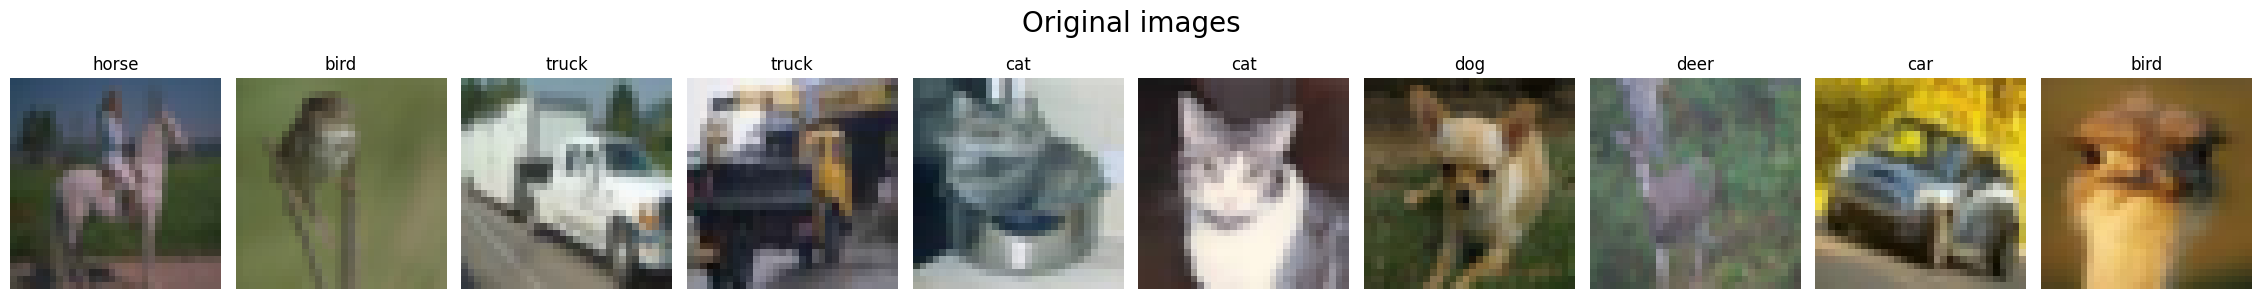

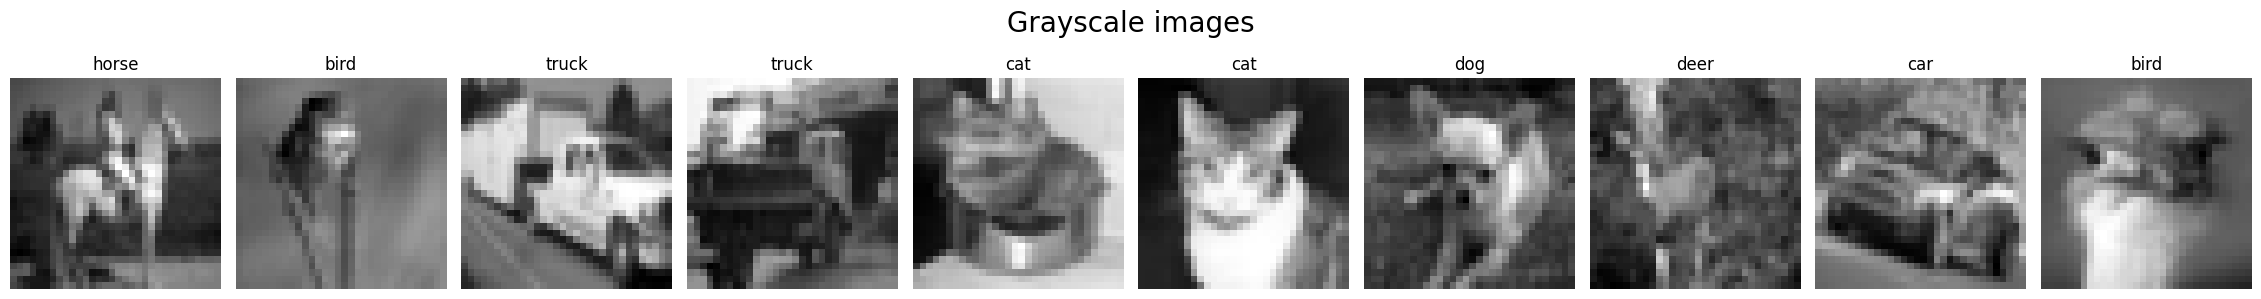

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 1/20: : 100%|██████████| 625/625 [01:04<00:00,  9.69it/s, Loss=0.000175]


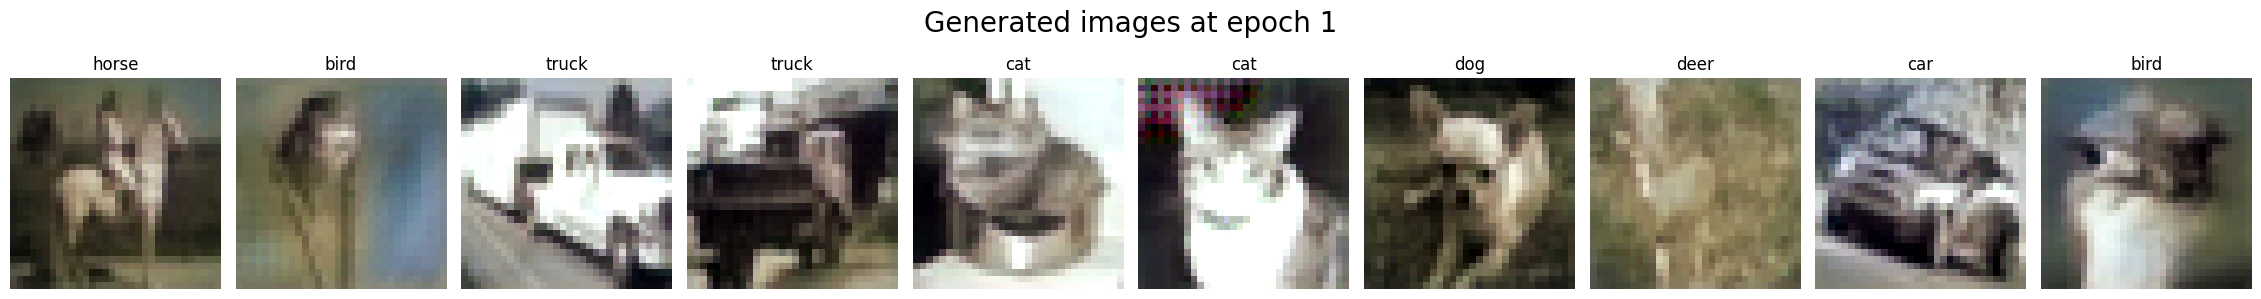

Adjusting learning rate of group 0 to 9.0000e-04.


Epoch 2/20: : 100%|██████████| 625/625 [01:04<00:00,  9.70it/s, Loss=8.61e-5]


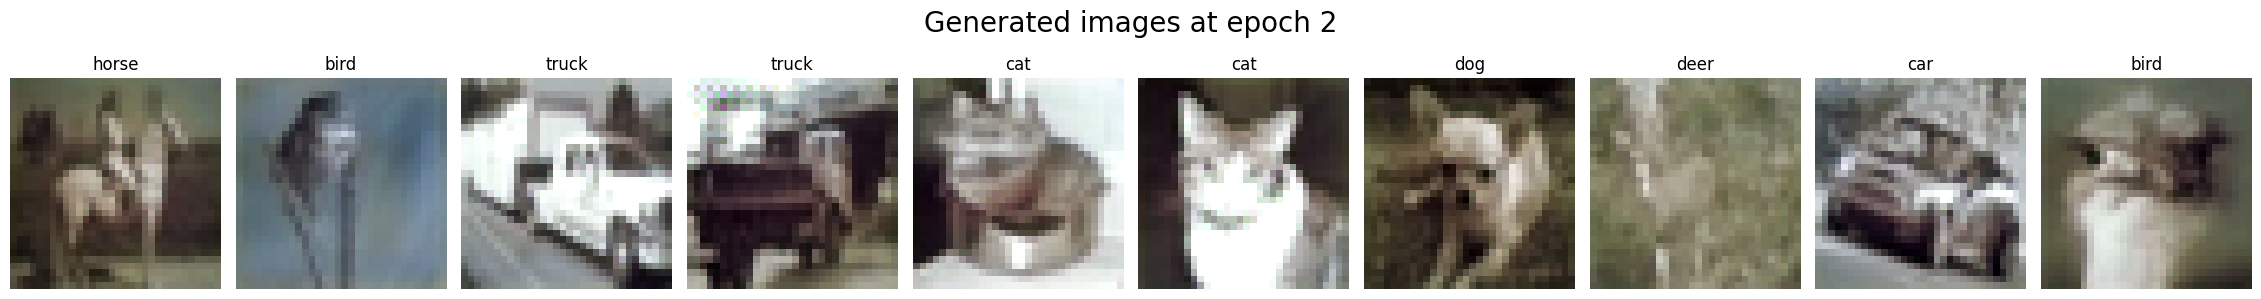

Adjusting learning rate of group 0 to 8.1000e-04.


Epoch 3/20: : 100%|██████████| 625/625 [01:05<00:00,  9.57it/s, Loss=8.32e-5]


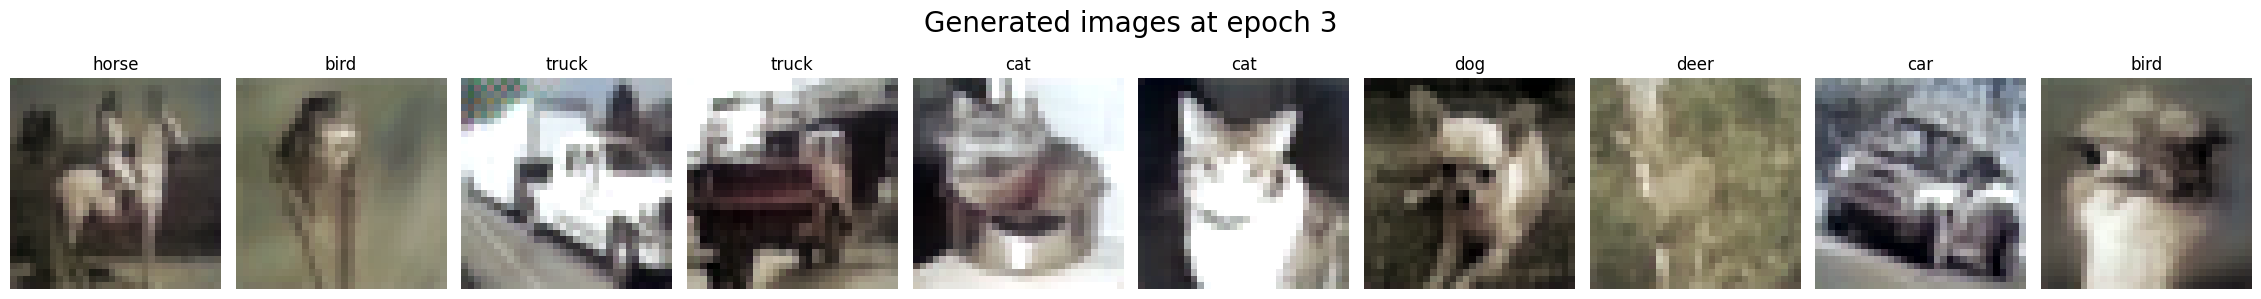

Adjusting learning rate of group 0 to 7.2900e-04.


Epoch 4/20: : 100%|██████████| 625/625 [01:04<00:00,  9.63it/s, Loss=8.21e-5]


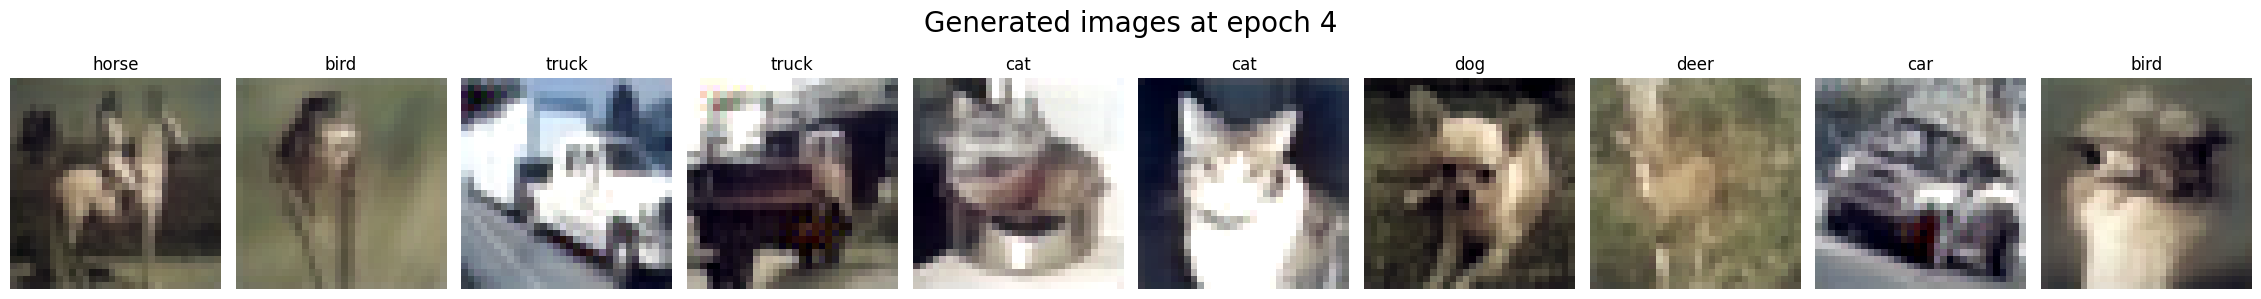

Adjusting learning rate of group 0 to 6.5610e-04.


Epoch 5/20: : 100%|██████████| 625/625 [01:05<00:00,  9.58it/s, Loss=8.02e-5]


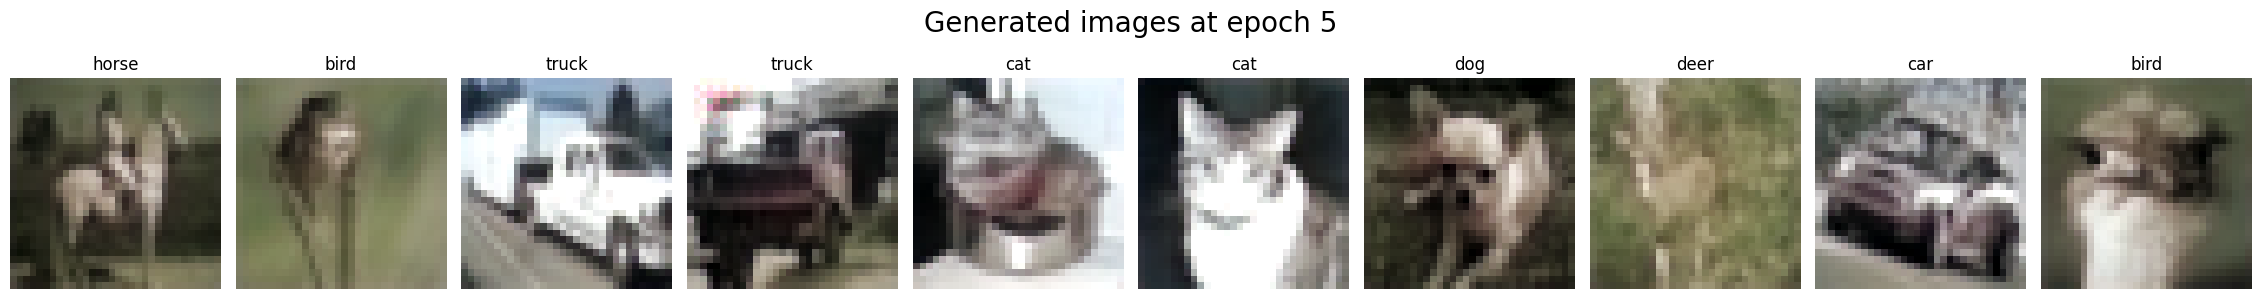

Adjusting learning rate of group 0 to 5.9049e-04.


Epoch 6/20: : 100%|██████████| 625/625 [01:04<00:00,  9.64it/s, Loss=7.87e-5]


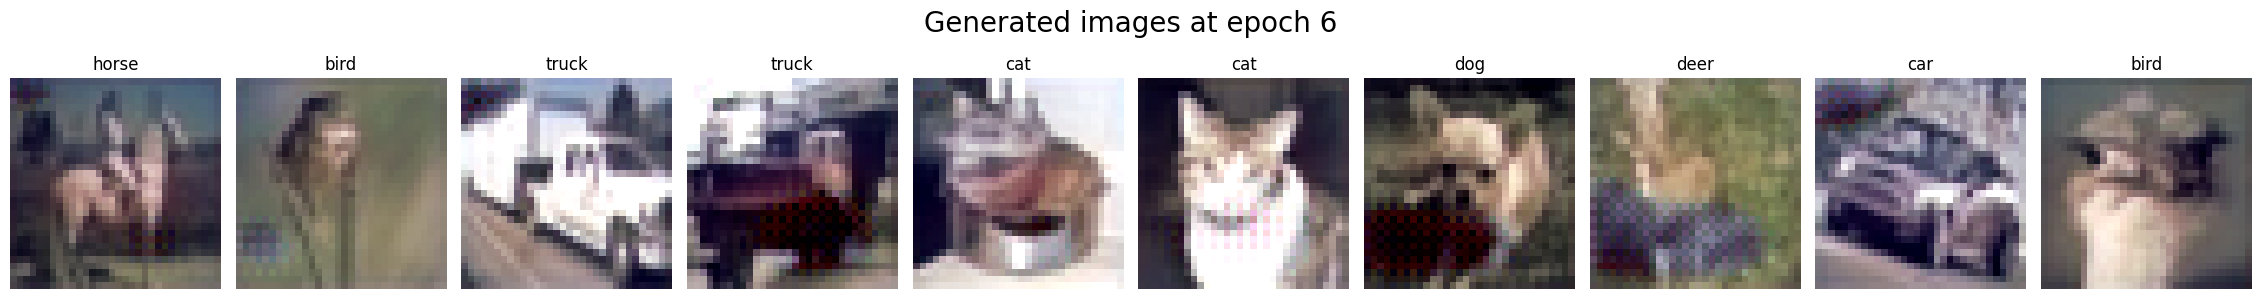

Adjusting learning rate of group 0 to 5.3144e-04.


Epoch 7/20: : 100%|██████████| 625/625 [01:05<00:00,  9.55it/s, Loss=7.89e-5]


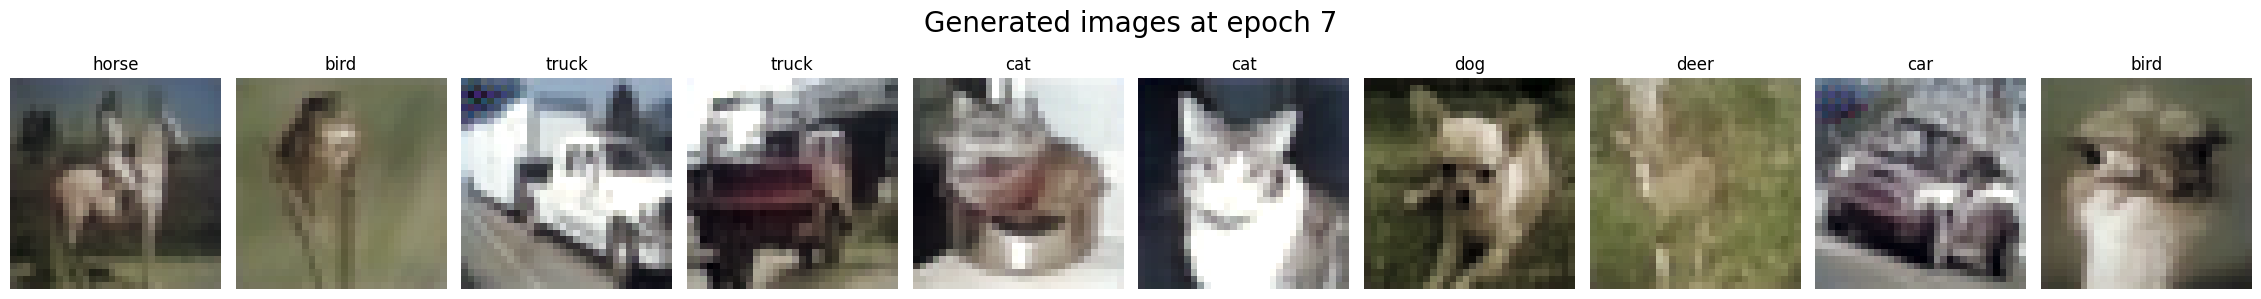

Adjusting learning rate of group 0 to 4.7830e-04.


Epoch 8/20: : 100%|██████████| 625/625 [01:05<00:00,  9.60it/s, Loss=7.74e-5]


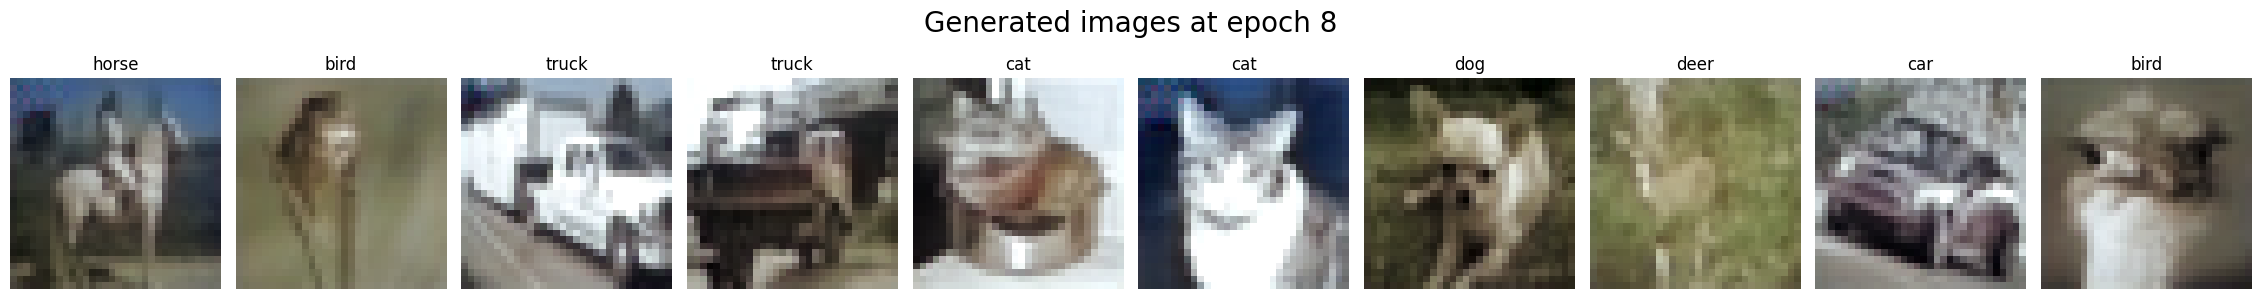

Adjusting learning rate of group 0 to 4.3047e-04.


Epoch 9/20: : 100%|██████████| 625/625 [01:04<00:00,  9.65it/s, Loss=7.56e-5]


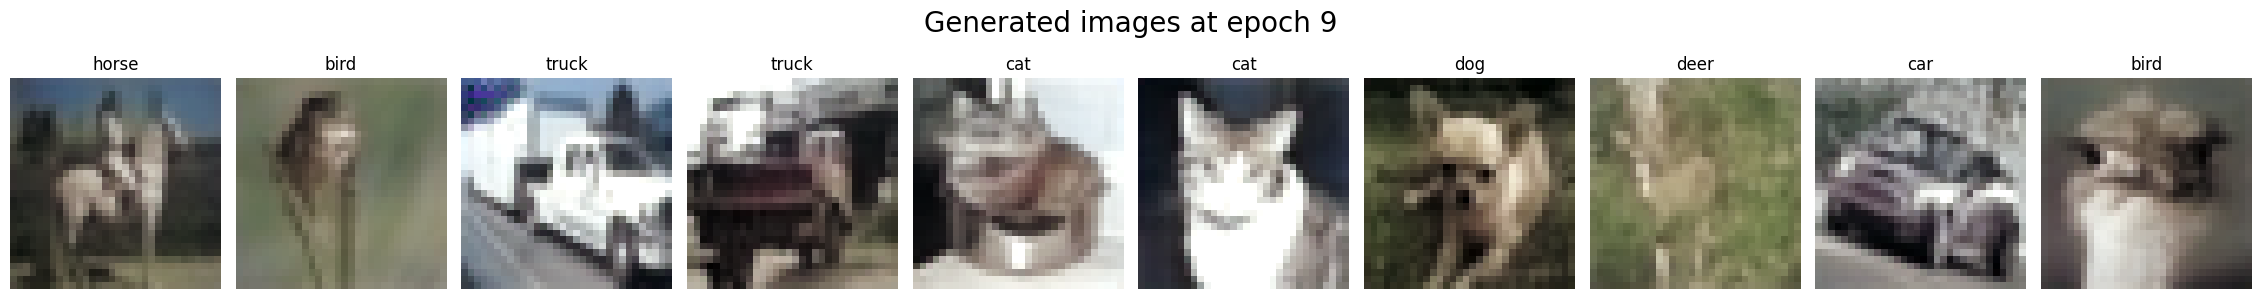

Adjusting learning rate of group 0 to 3.8742e-04.


Epoch 10/20: : 100%|██████████| 625/625 [01:04<00:00,  9.66it/s, Loss=7.53e-5]


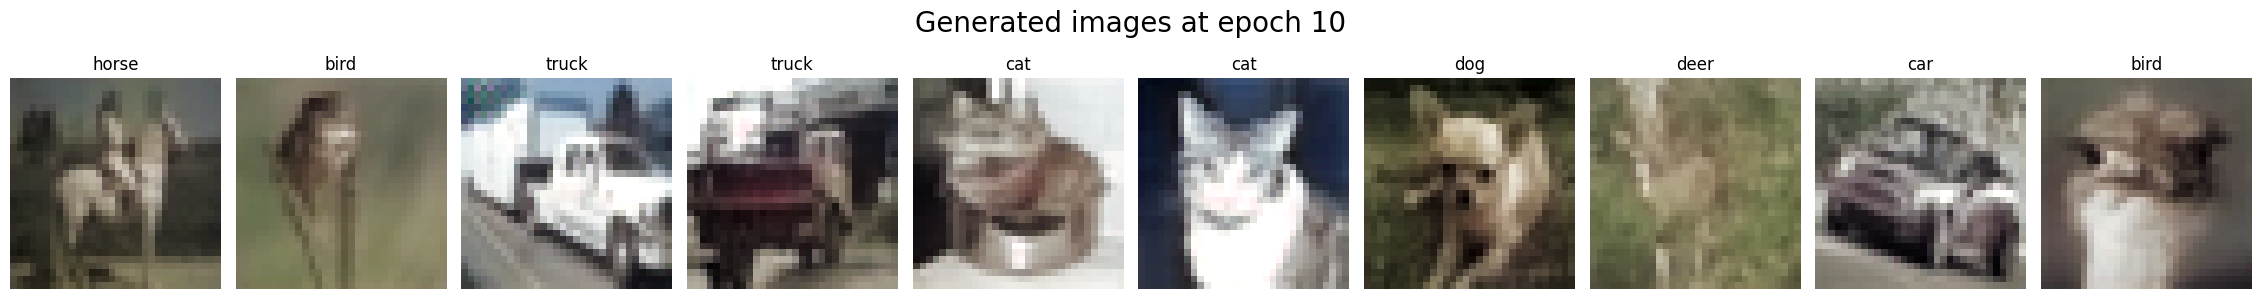

Adjusting learning rate of group 0 to 3.4868e-04.


Epoch 11/20: : 100%|██████████| 625/625 [01:04<00:00,  9.68it/s, Loss=7.39e-5]


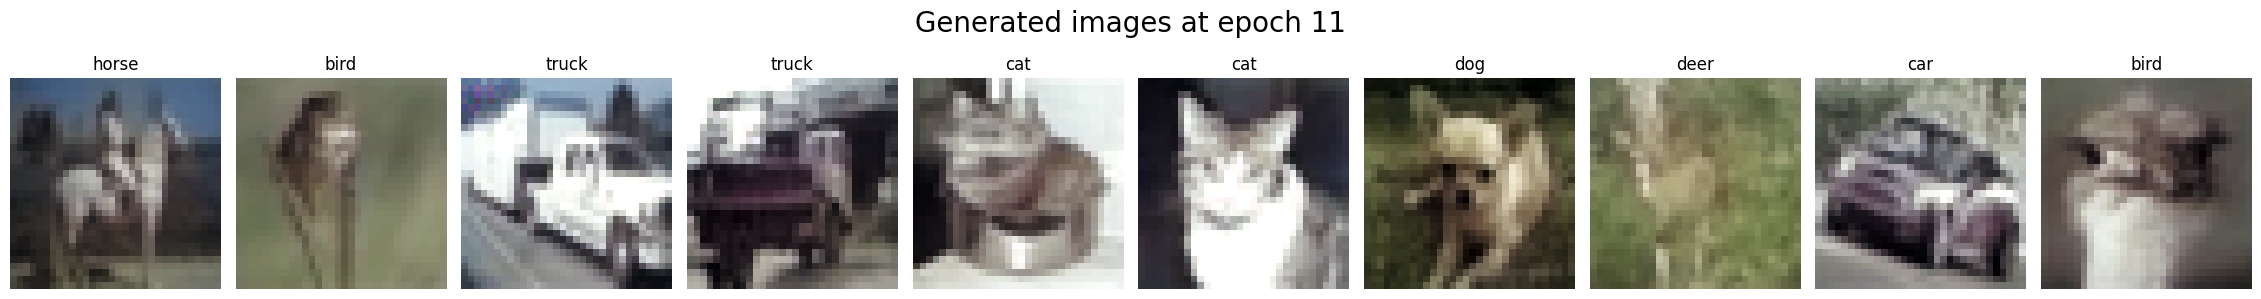

Adjusting learning rate of group 0 to 3.1381e-04.


Epoch 12/20: : 100%|██████████| 625/625 [01:04<00:00,  9.64it/s, Loss=7.34e-5]


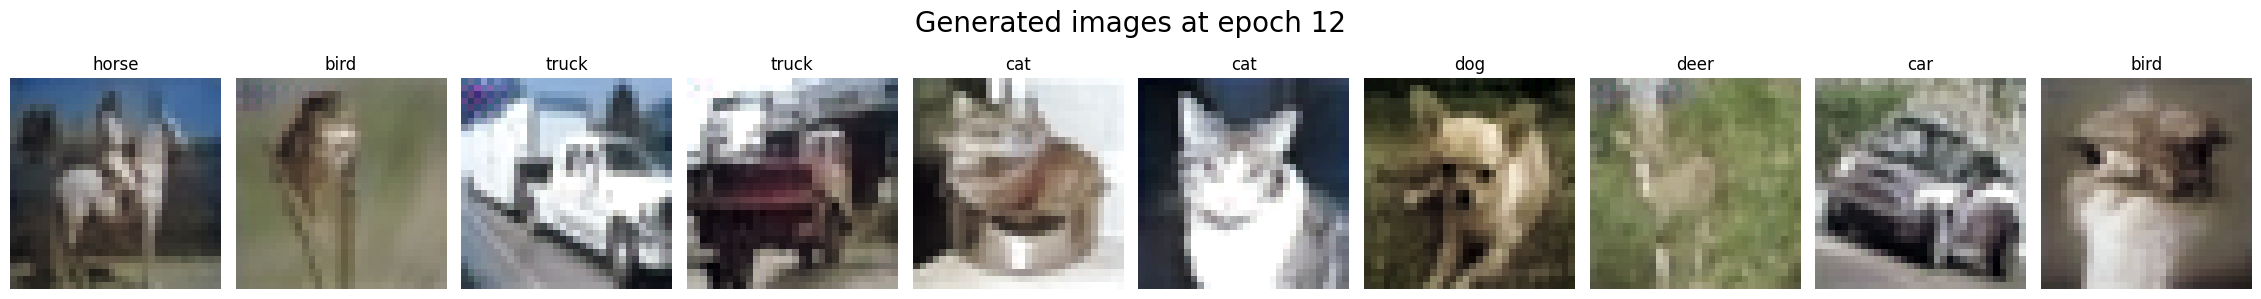

Adjusting learning rate of group 0 to 2.8243e-04.


Epoch 13/20: : 100%|██████████| 625/625 [01:05<00:00,  9.61it/s, Loss=7.19e-5]


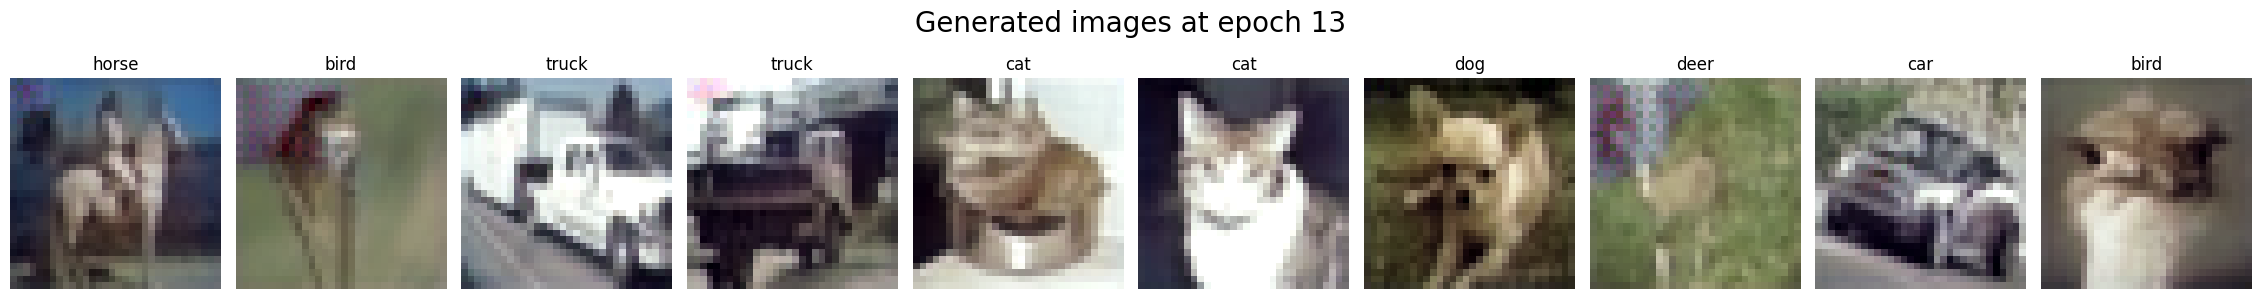

Adjusting learning rate of group 0 to 2.5419e-04.


Epoch 14/20: : 100%|██████████| 625/625 [01:05<00:00,  9.58it/s, Loss=7.04e-5]


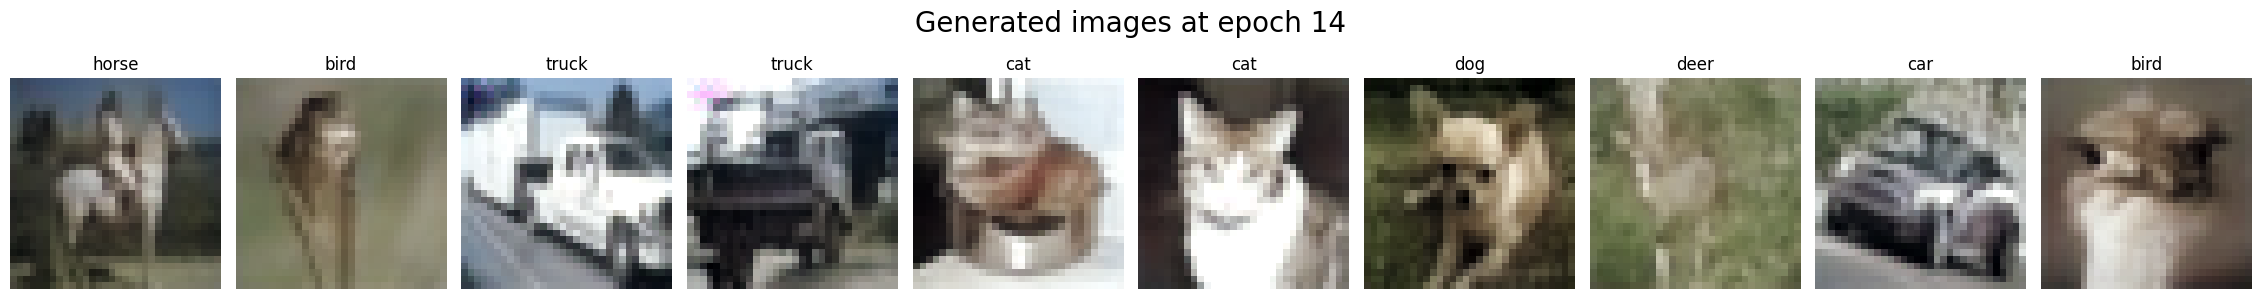

Adjusting learning rate of group 0 to 2.2877e-04.


Epoch 15/20: : 100%|██████████| 625/625 [01:05<00:00,  9.60it/s, Loss=6.92e-5]


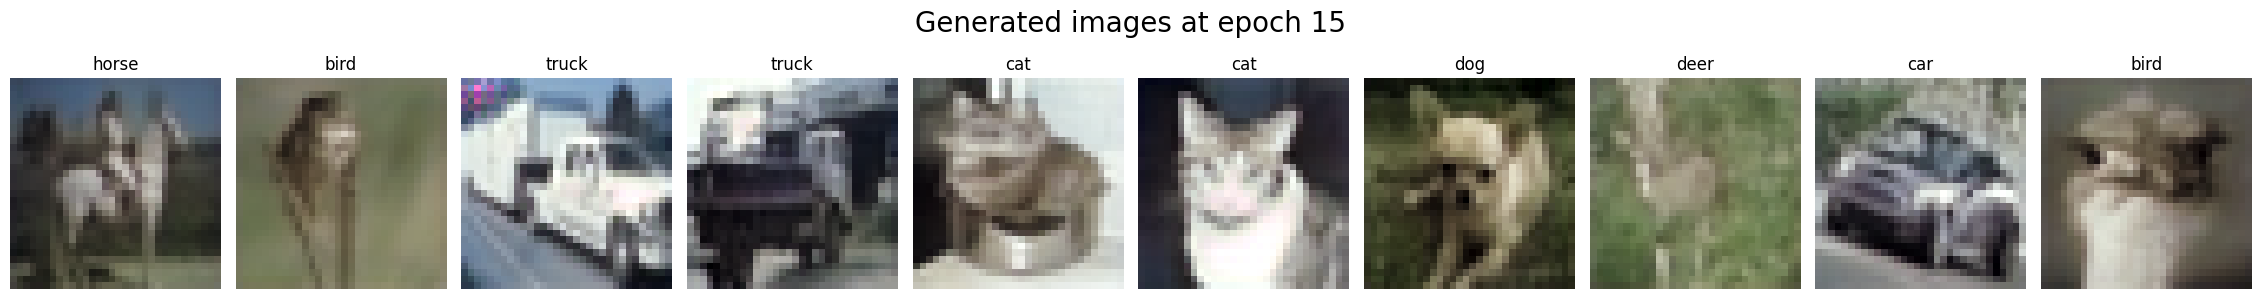

Adjusting learning rate of group 0 to 2.0589e-04.


Epoch 16/20: : 100%|██████████| 625/625 [01:05<00:00,  9.58it/s, Loss=6.75e-5]


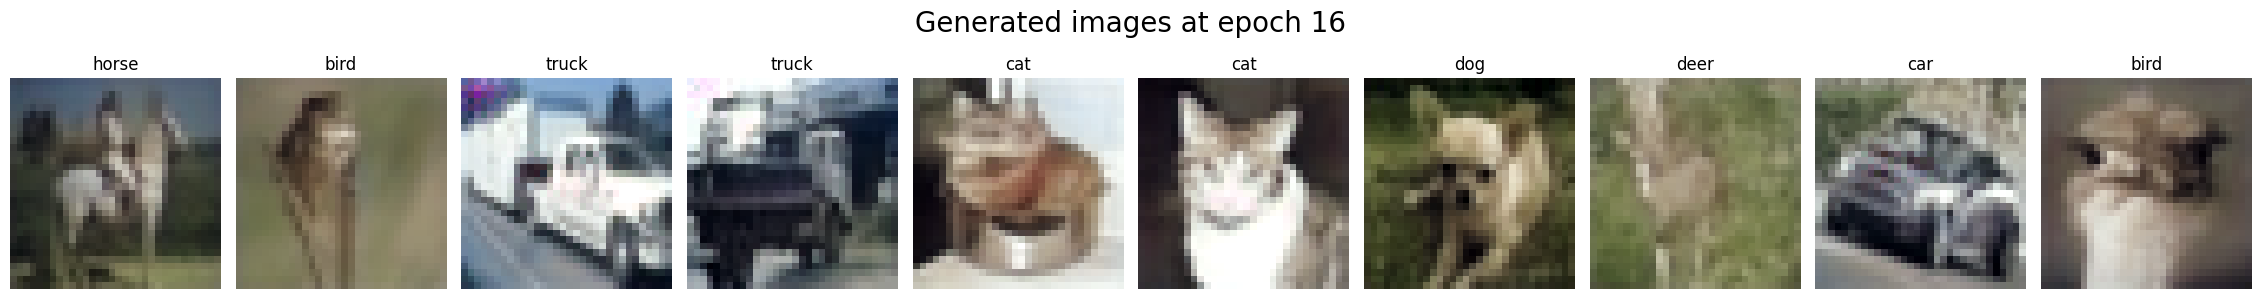

Adjusting learning rate of group 0 to 1.8530e-04.


Epoch 17/20: : 100%|██████████| 625/625 [01:05<00:00,  9.59it/s, Loss=6.62e-5]


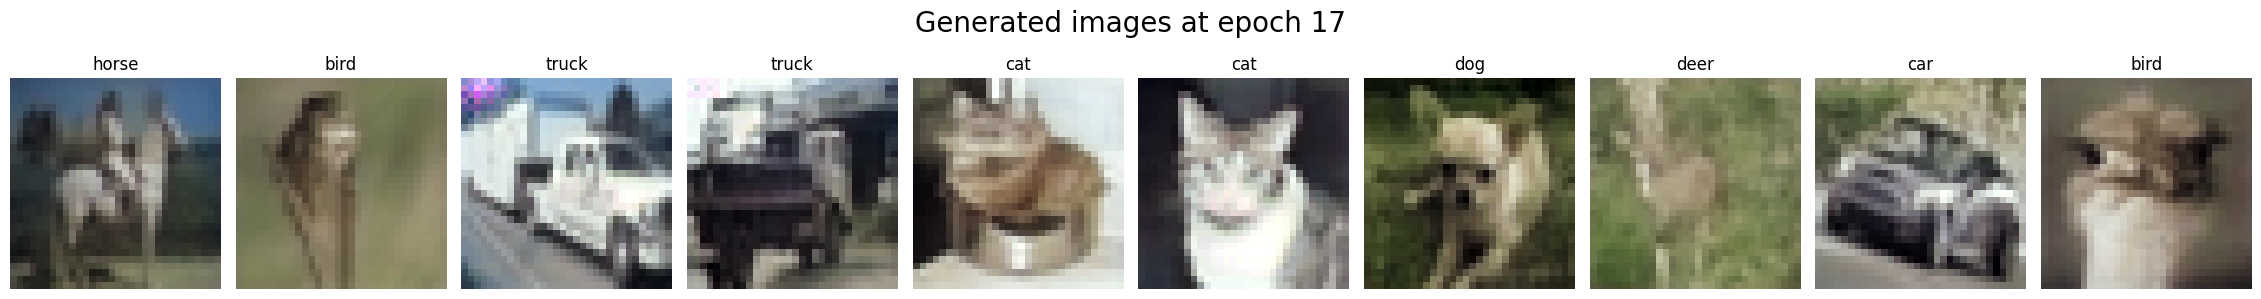

Adjusting learning rate of group 0 to 1.6677e-04.


Epoch 18/20: : 100%|██████████| 625/625 [01:05<00:00,  9.52it/s, Loss=6.44e-5]


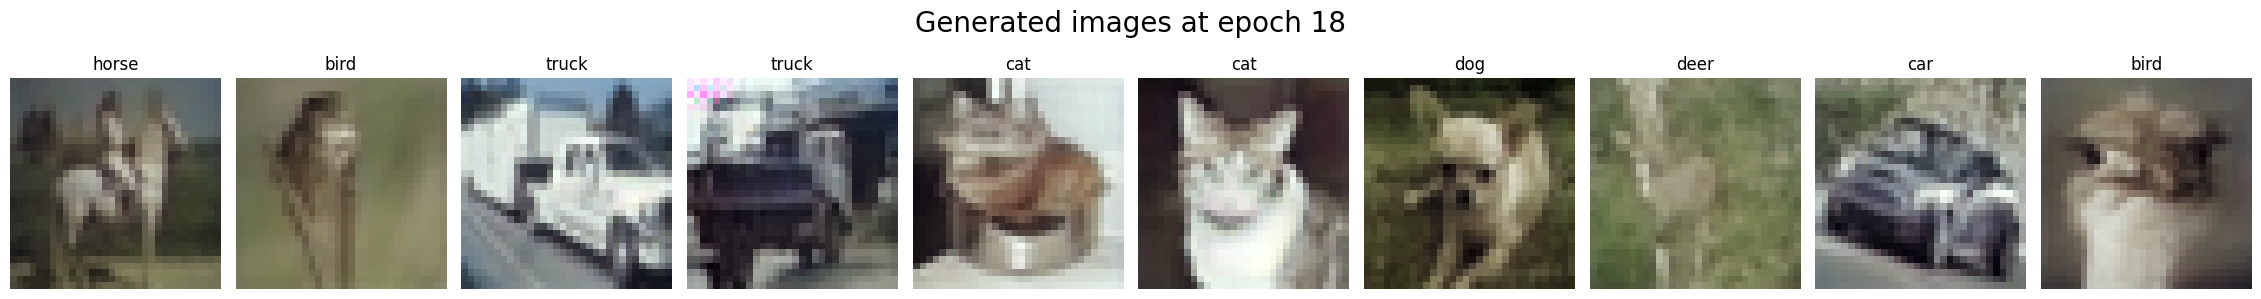

Adjusting learning rate of group 0 to 1.5009e-04.


Epoch 19/20: : 100%|██████████| 625/625 [01:05<00:00,  9.55it/s, Loss=6.26e-5]


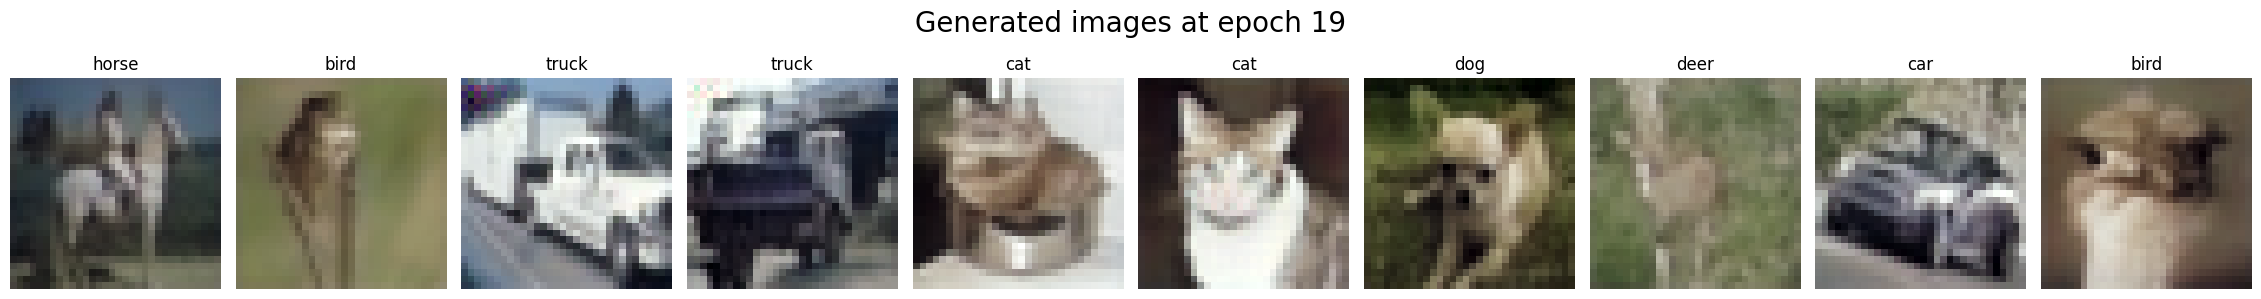

Adjusting learning rate of group 0 to 1.3509e-04.


Epoch 20/20: : 100%|██████████| 625/625 [01:05<00:00,  9.52it/s, Loss=6.06e-5]


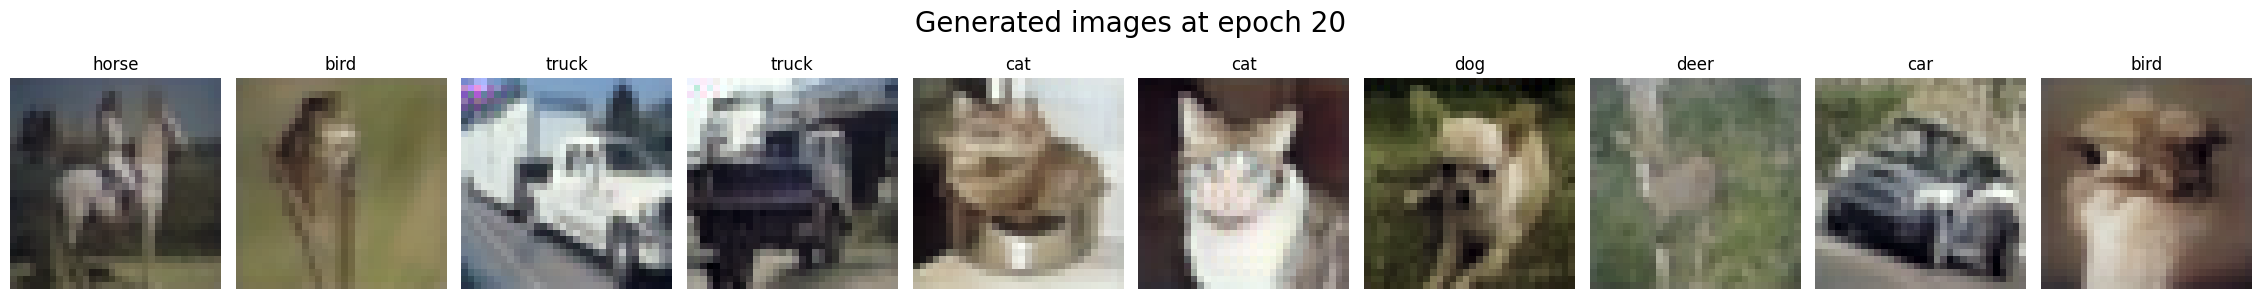

Adjusting learning rate of group 0 to 1.2158e-04.


In [123]:
losses_tr, losses_val = trainAE(model, train_loader, valid_loader, num_epochs=20, loss_fn=loss_fn, optimizer=optimizer, device=device)

In [124]:
def plot_losses(losses_tr, losses_val):
  plt.figure(figsize=(10, 6))
  plt.plot(losses_tr, label='Training Loss', color='blue')
  plt.plot(losses_val, label='Validation Loss', color='red')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Generator Losses')
  plt.legend()
  plt.grid(True)
  plt.show()

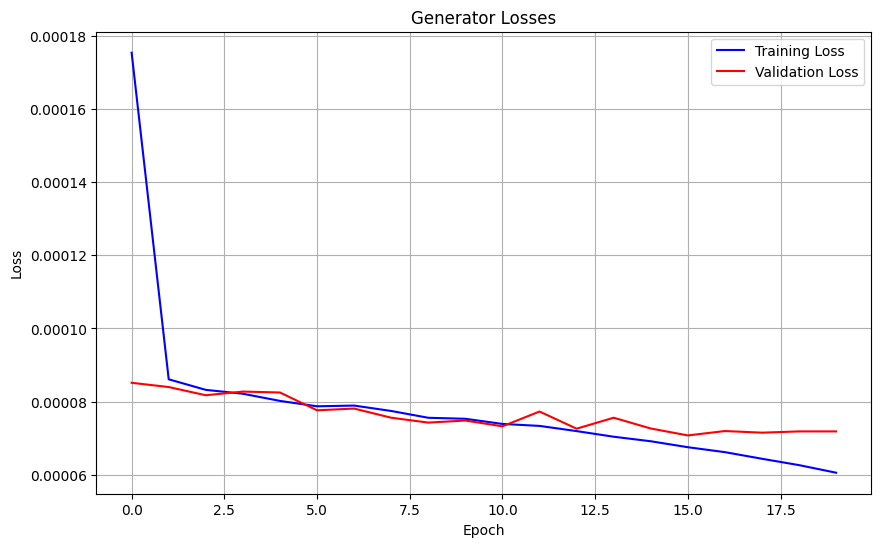

In [125]:
plot_losses(losses_tr, losses_val)

In [126]:
def test_AE(model, test_loader, loss_fn):
    model.eval()

    n_batch = 0
    total_loss = 0.0
    num_samples = 0

    with torch.no_grad():
      for batch in valid_loader:
        original_images, classes = batch
        classes = classes.to(device)
        X = original_images.to(device)
        grayscale_images = convert_to_grayscale(original_images)
        Xg = grayscale_images.to(device)
        Xhat = model(Xg)
        loss = loss_fn(Xhat, X)

        total_loss += loss.item()
        num_samples += X.size(0)

        if (n_batch <= 10):
          print("Batch", n_batch+1)
          # Extract labels from the test_loader
          labels = classes.cpu().numpy()

          generated_batch = (Xhat.cpu() * 255).clamp(0, 255).to(torch.uint8)

          # Display original images
          display_image_grid(original_images, labels, 1, 10, "Original Images")

          # Display grayscale images
          display_image_grid(grayscale_images, labels, 1, 10, "Grayscale Images")

          # Display generated images
          display_image_grid(generated_batch, labels, 1, 10, "Generated Images")

          n_batch+=1

    print("Test loss:", total_loss/num_samples)

Batch 1


<ipython-input-119-ed980bec2877>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


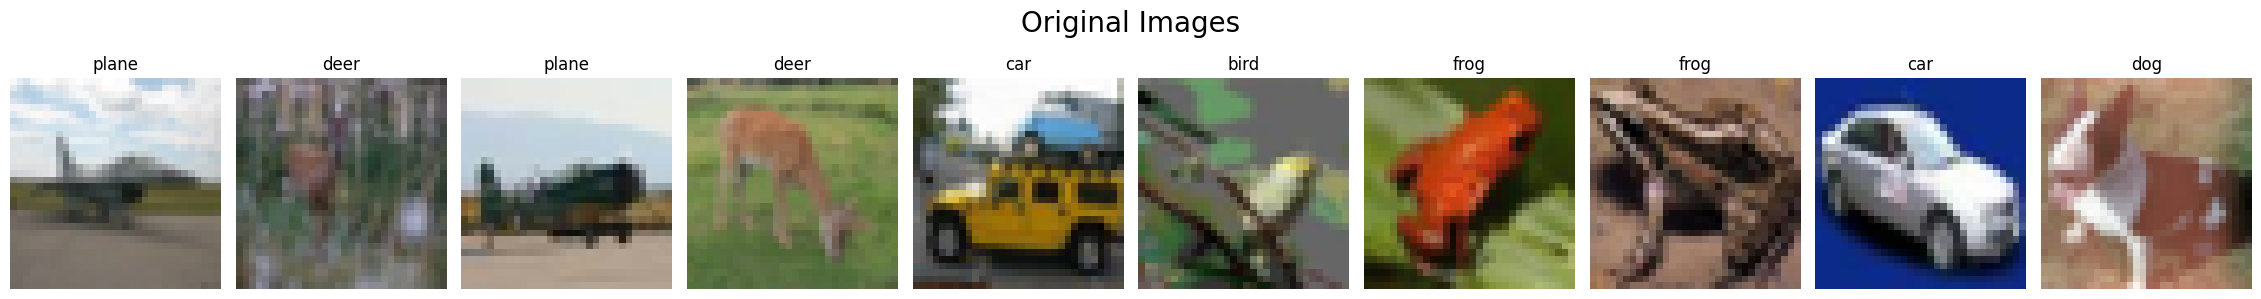

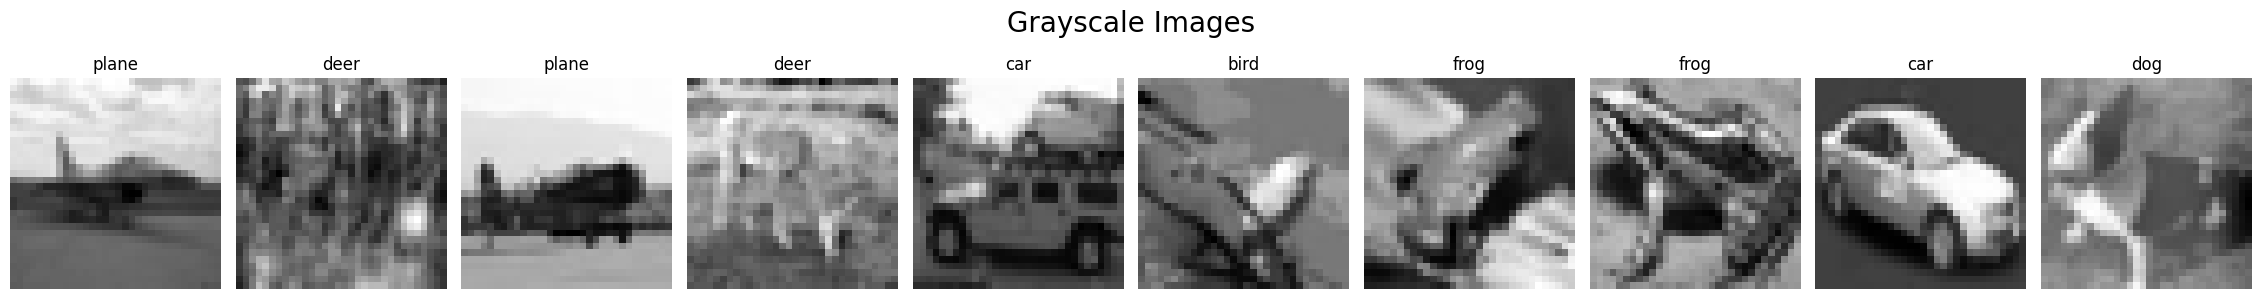

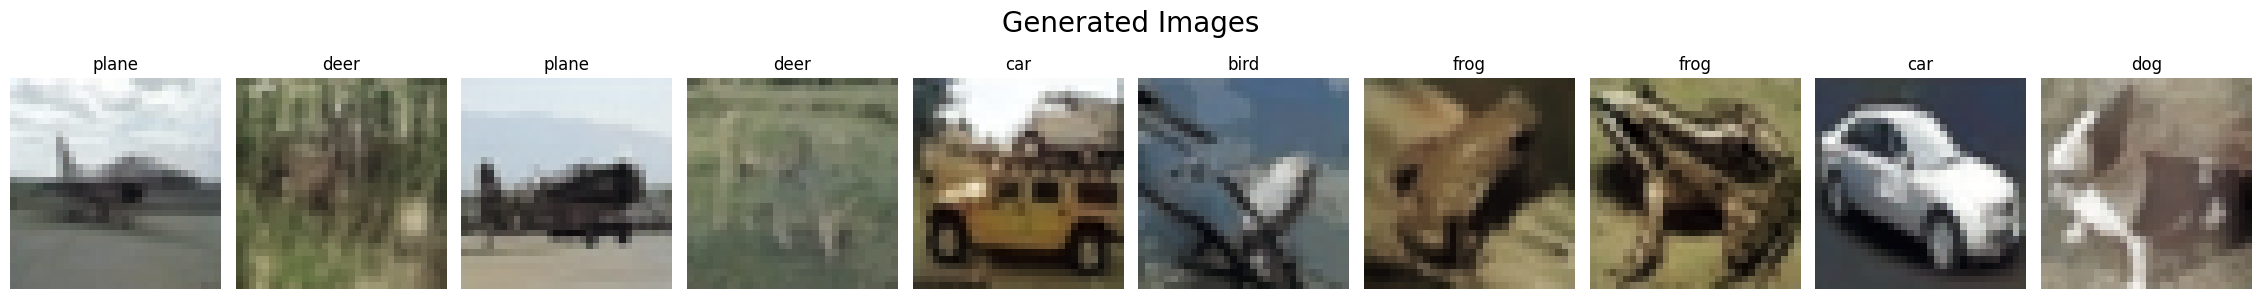

Batch 2


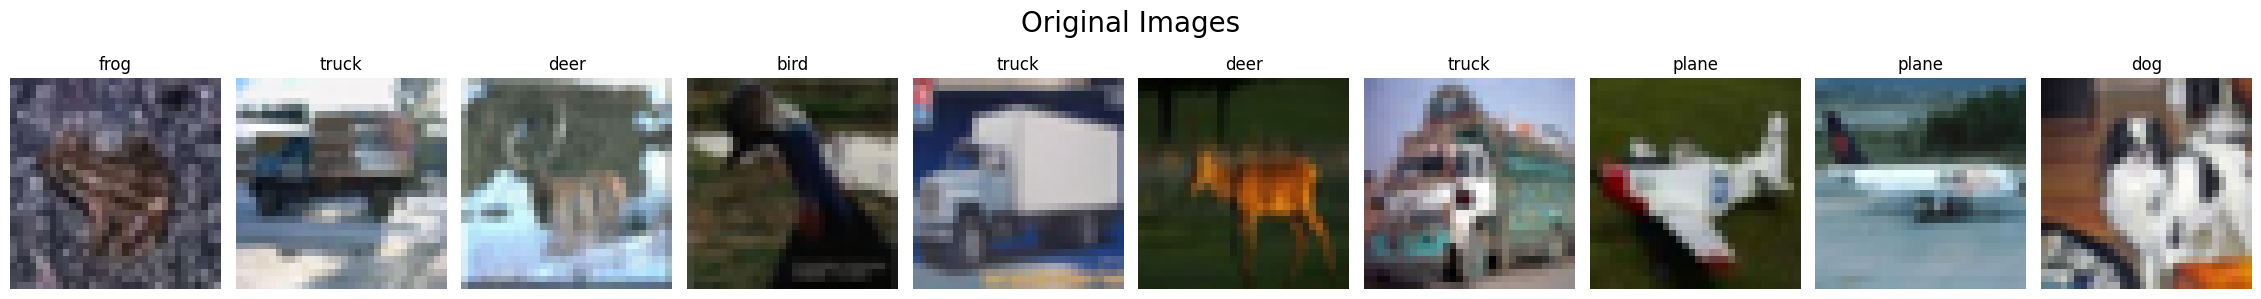

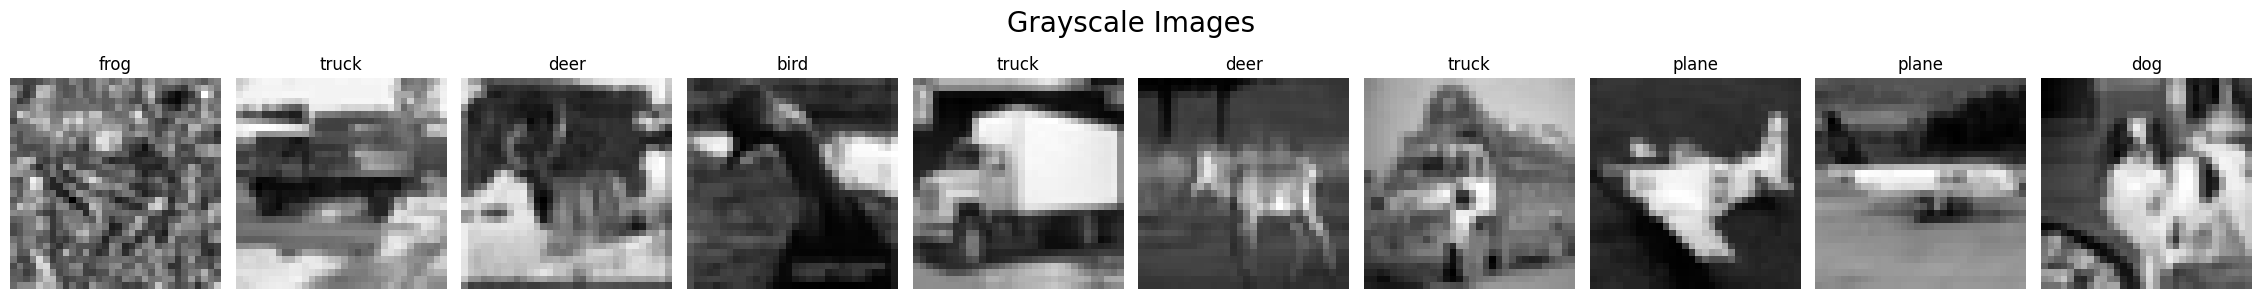

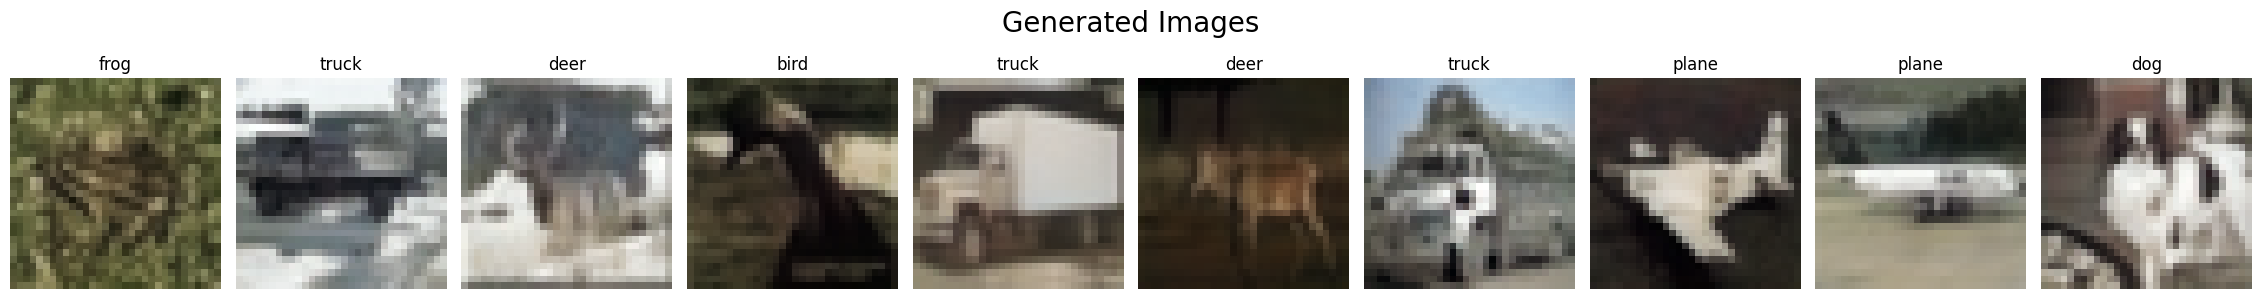

Batch 3


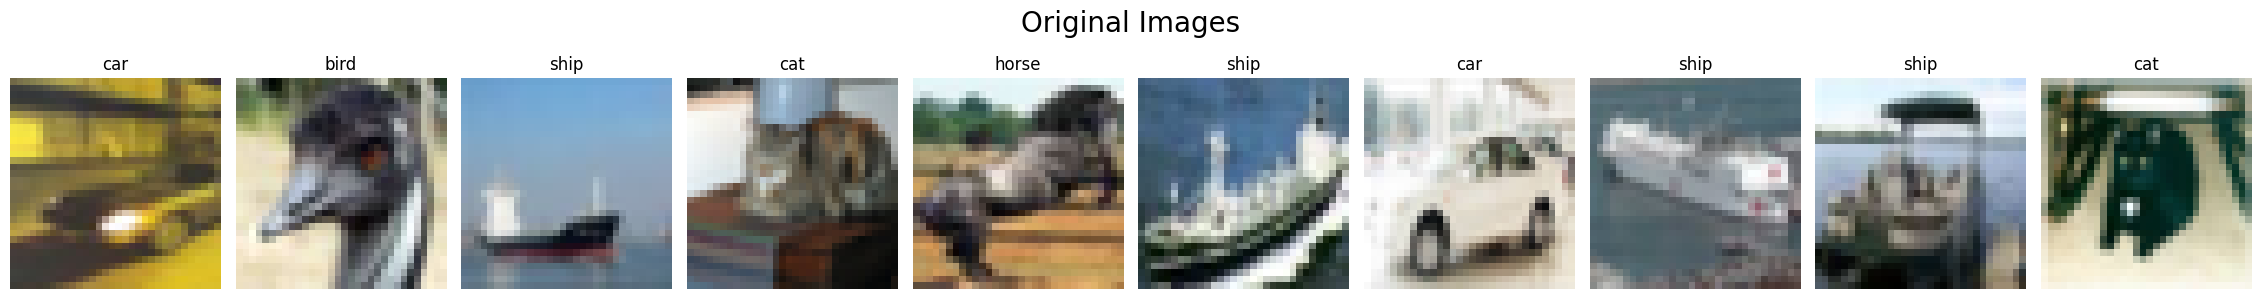

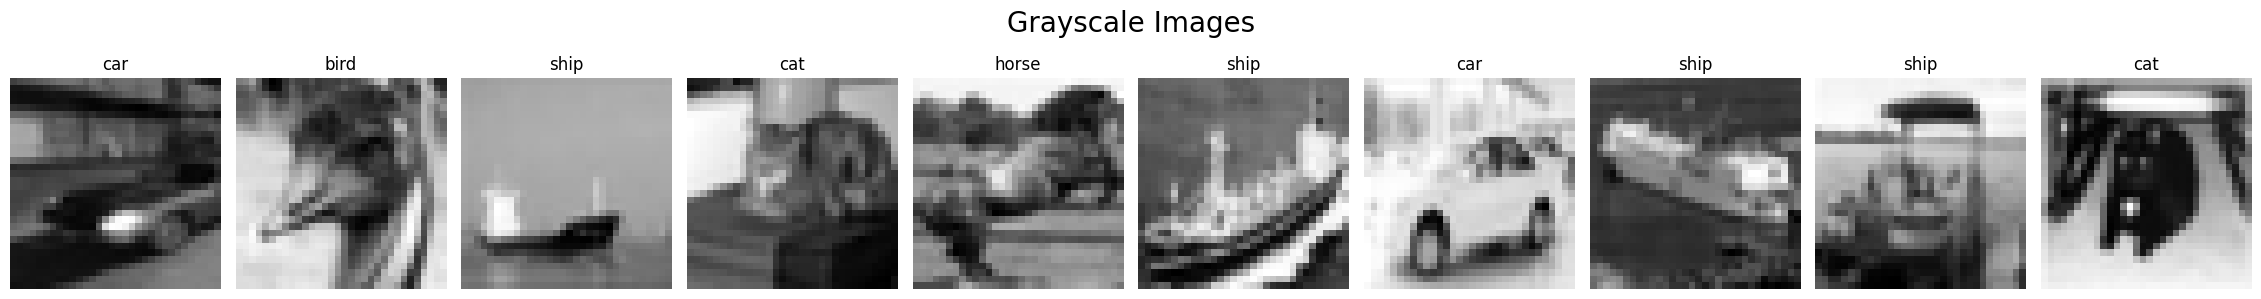

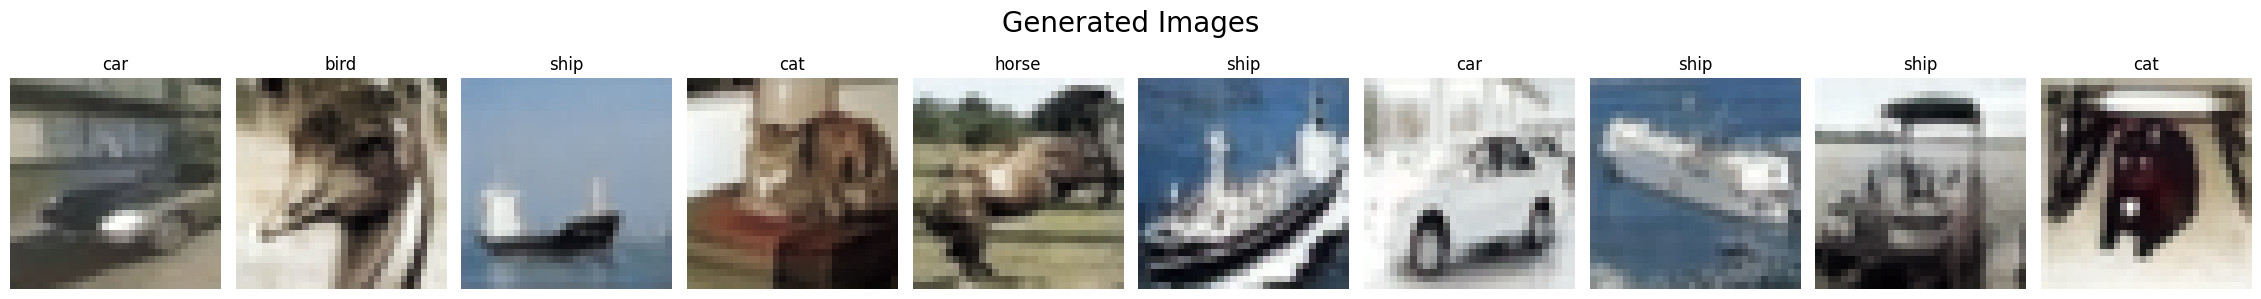

Batch 4


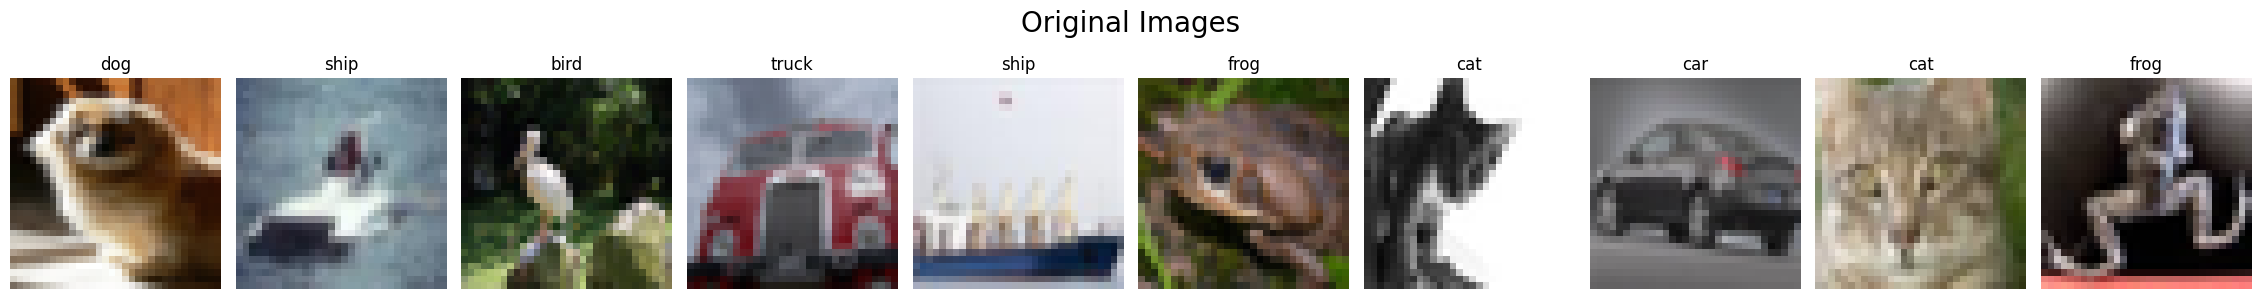

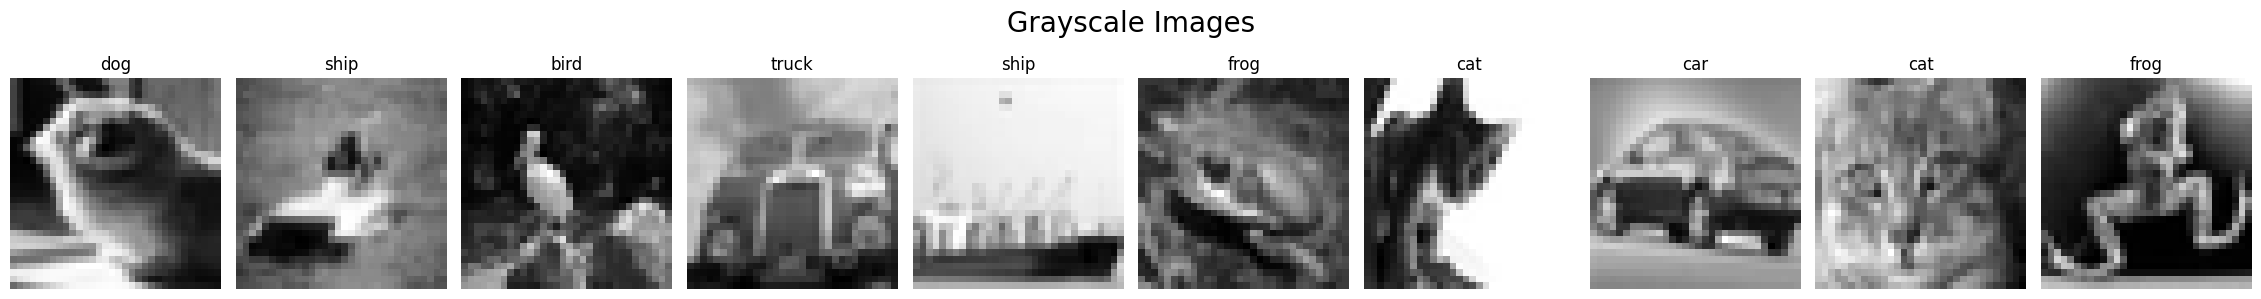

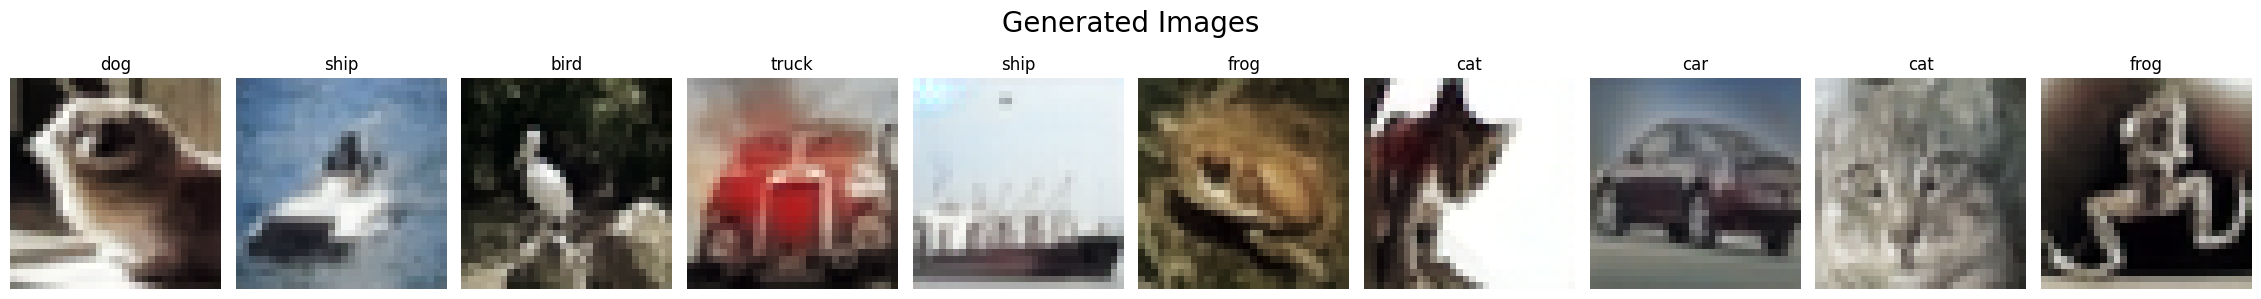

Batch 5


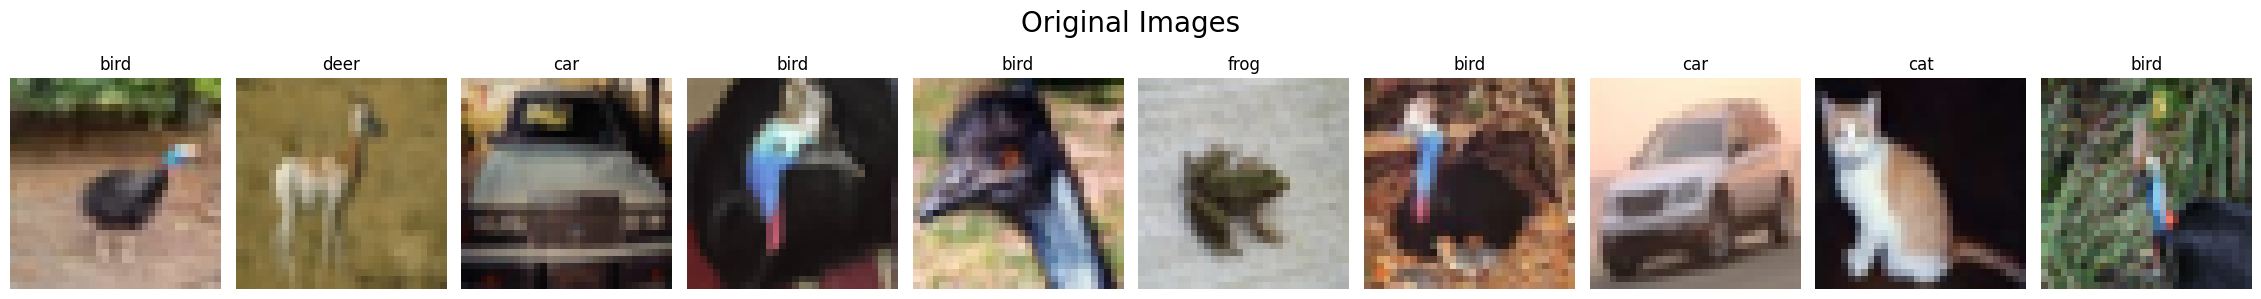

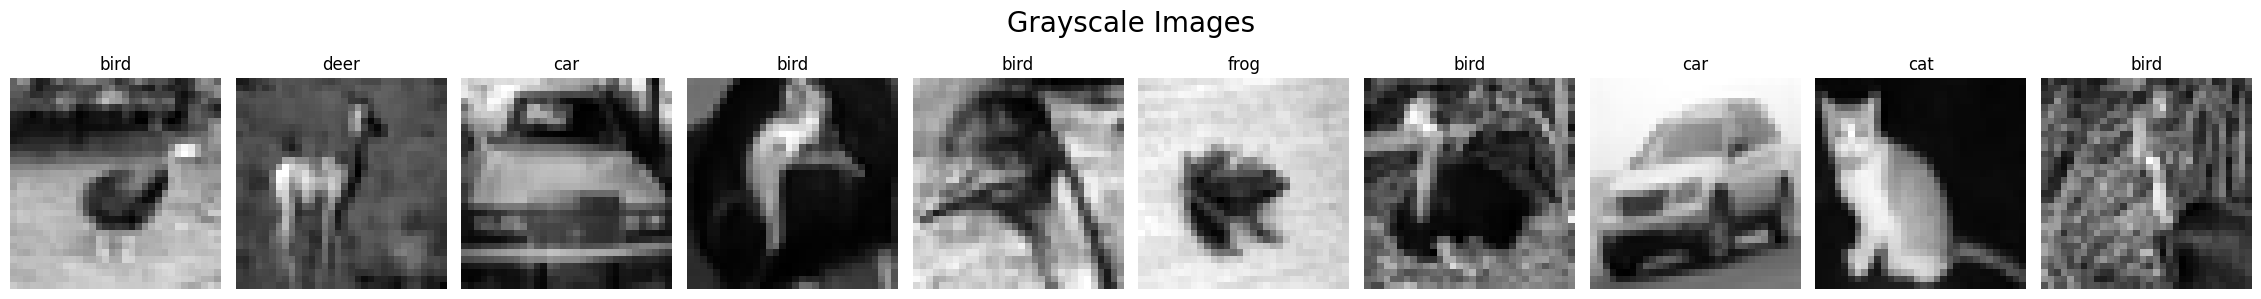

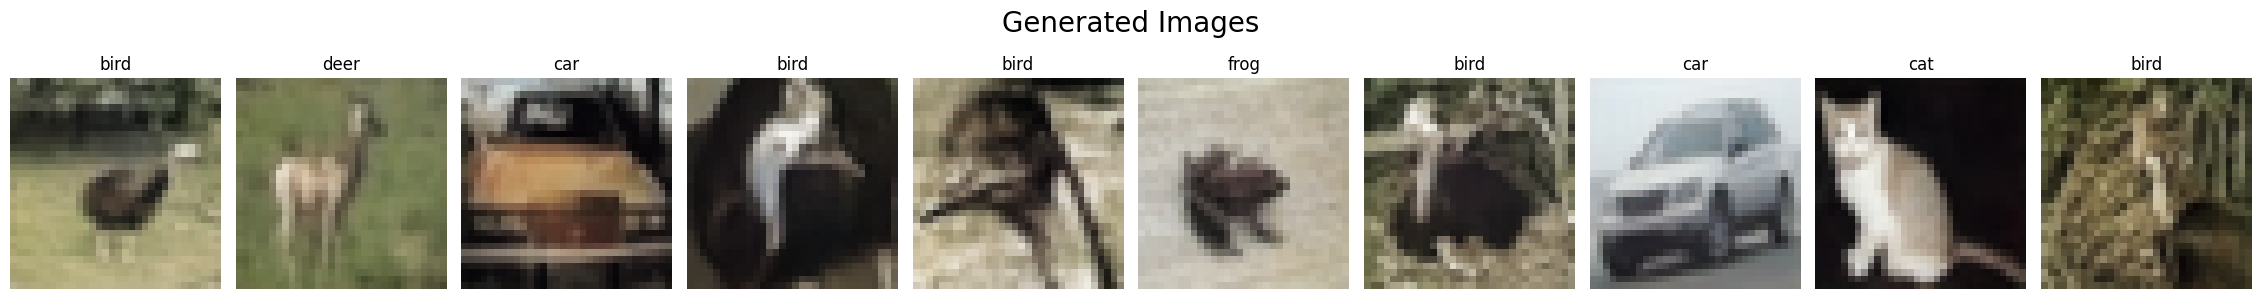

Batch 6


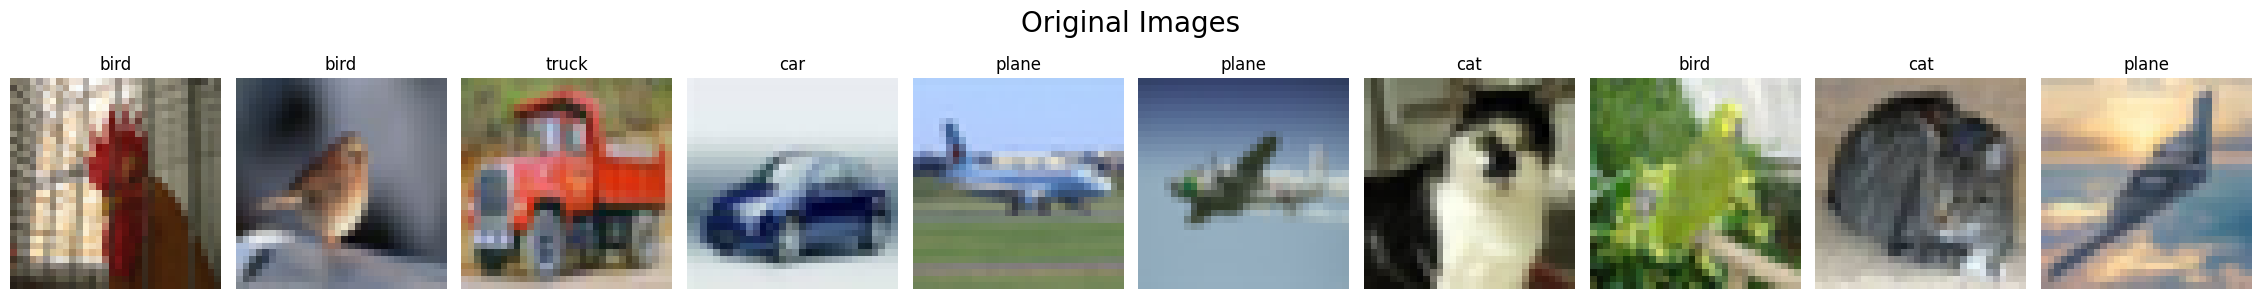

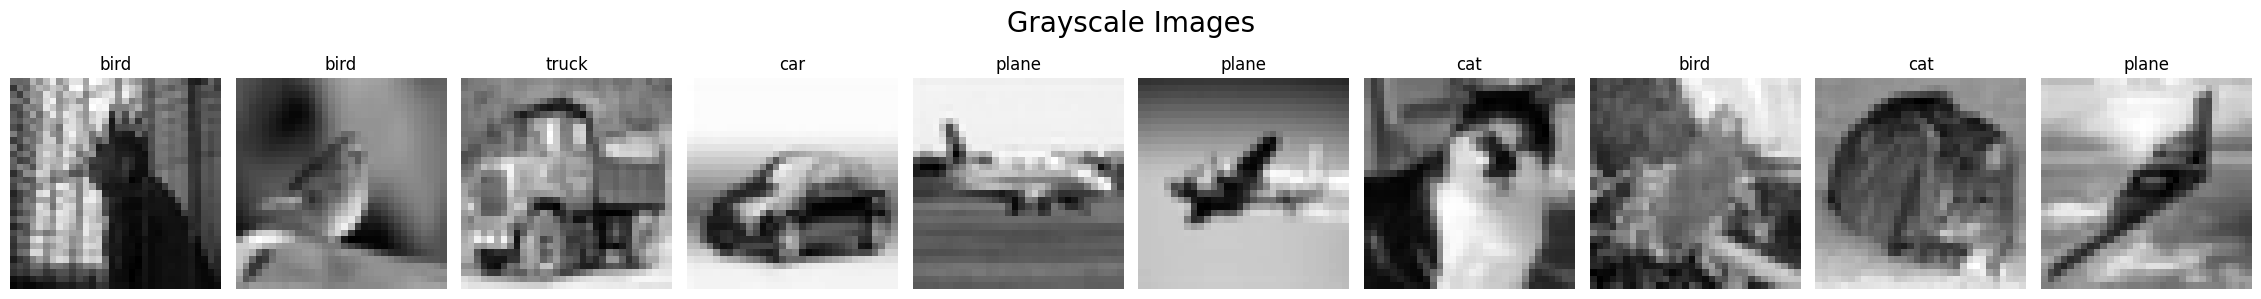

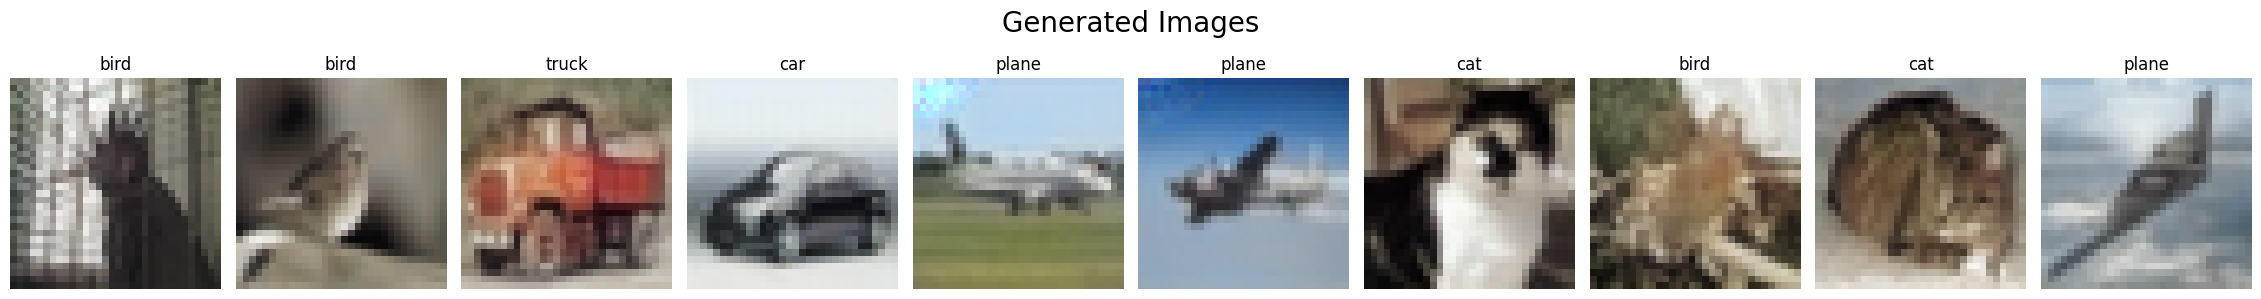

Batch 7


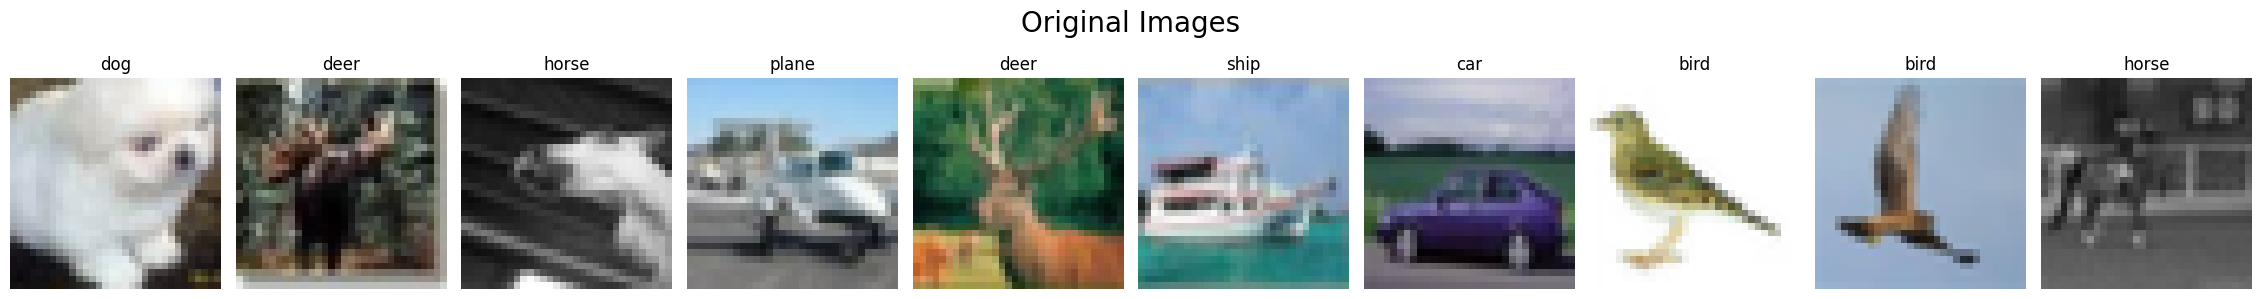

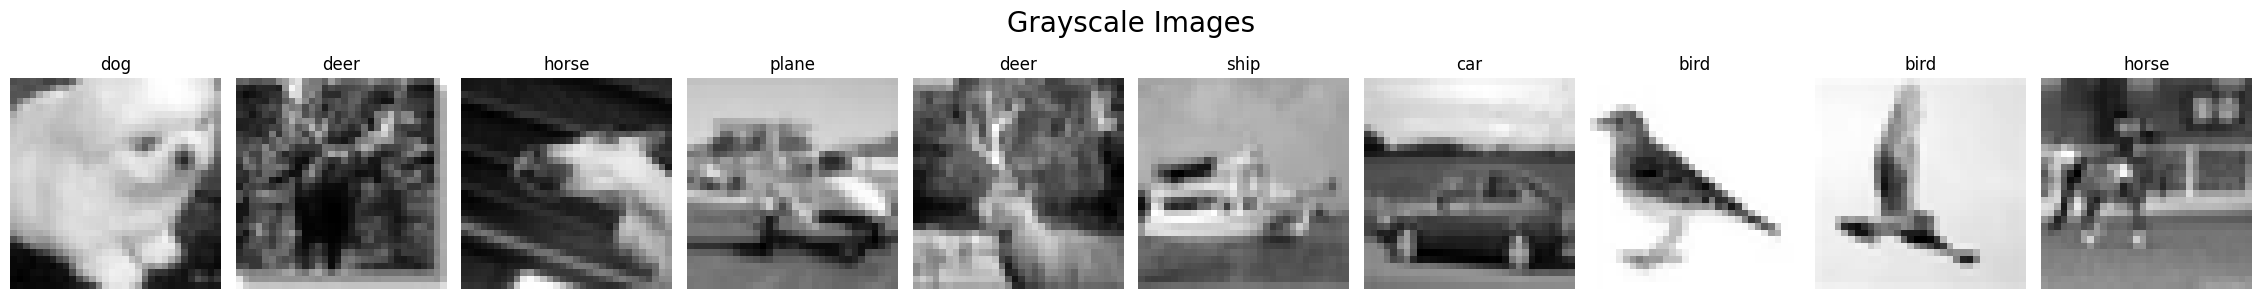

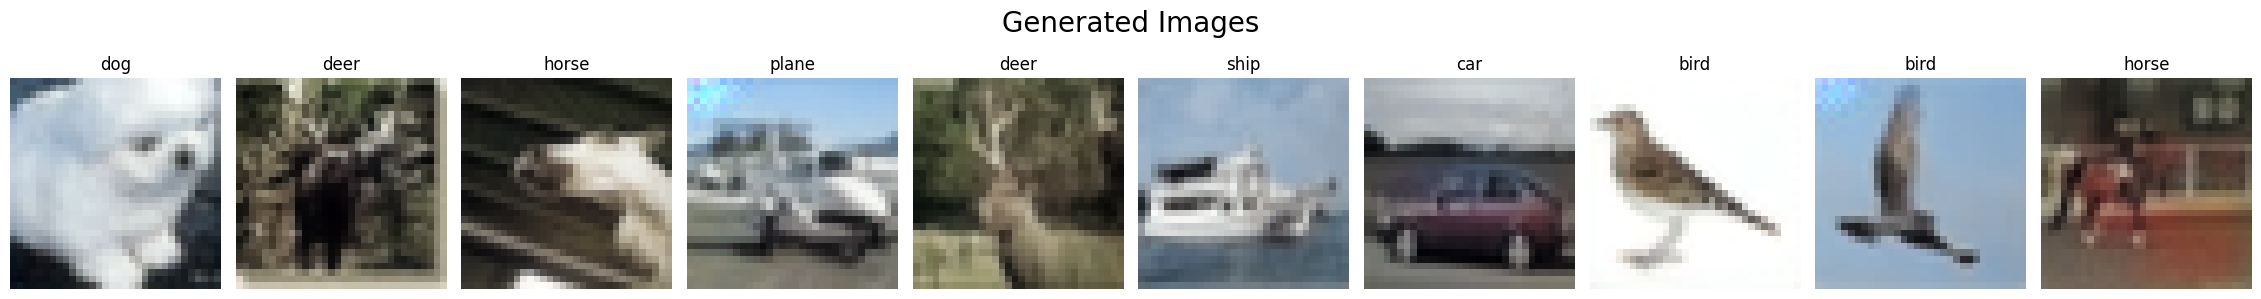

Batch 8


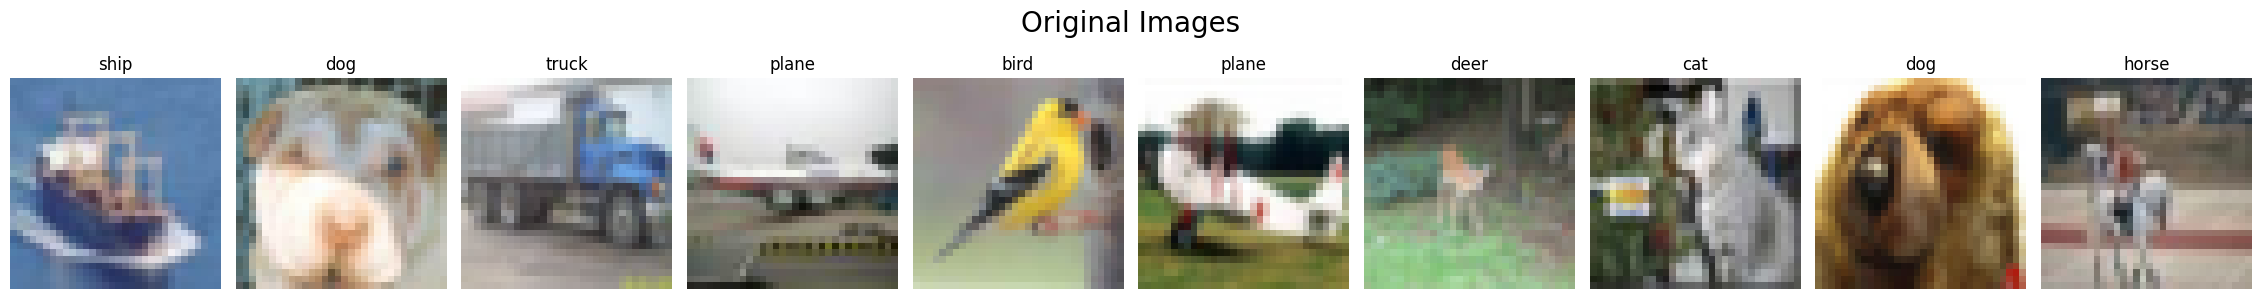

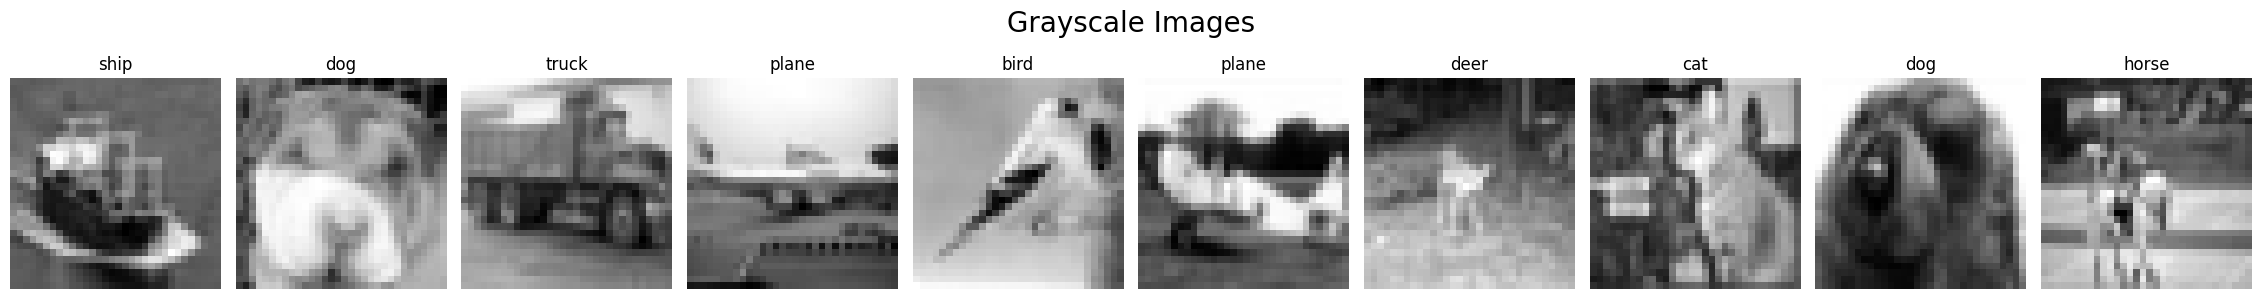

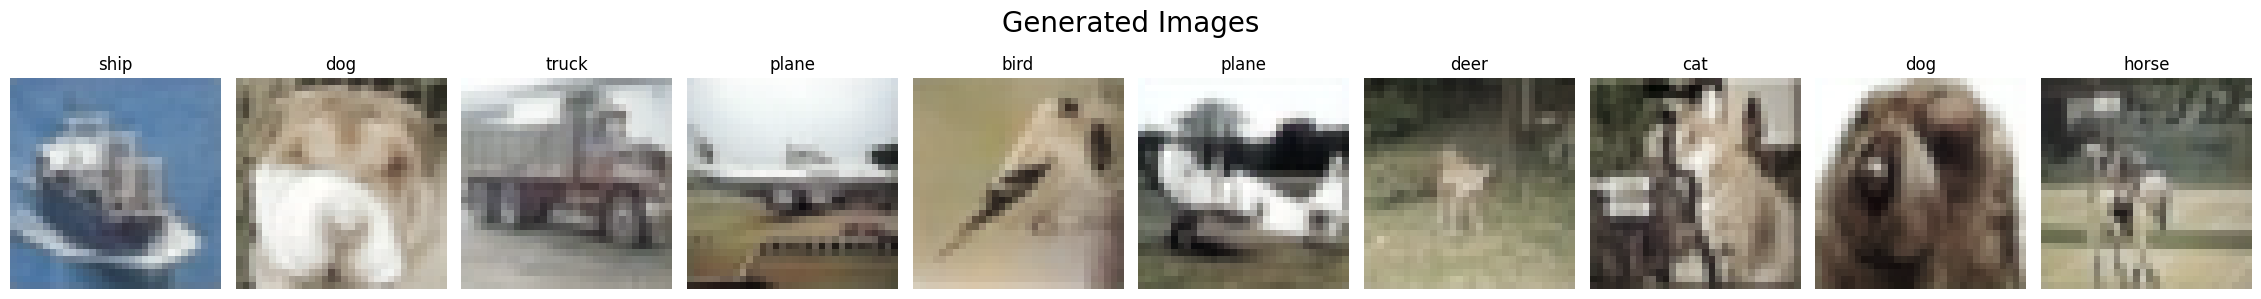

Batch 9


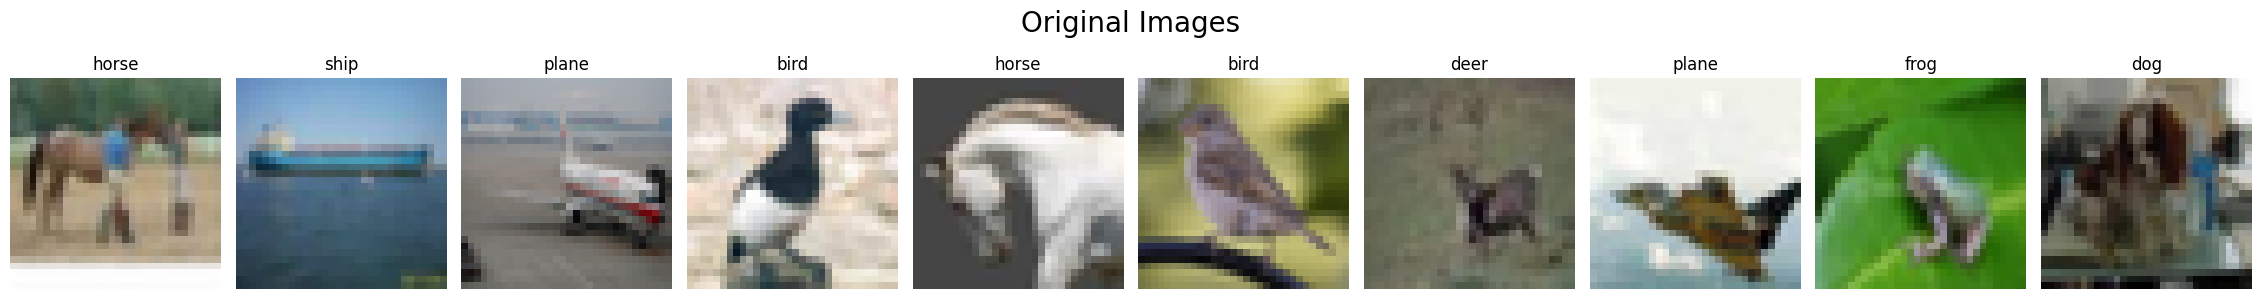

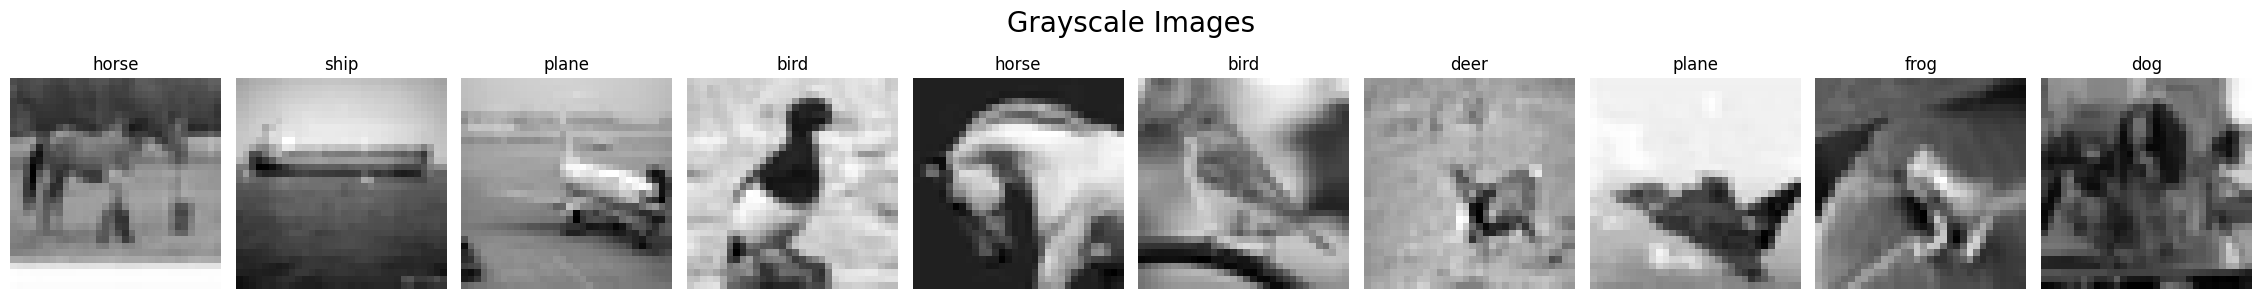

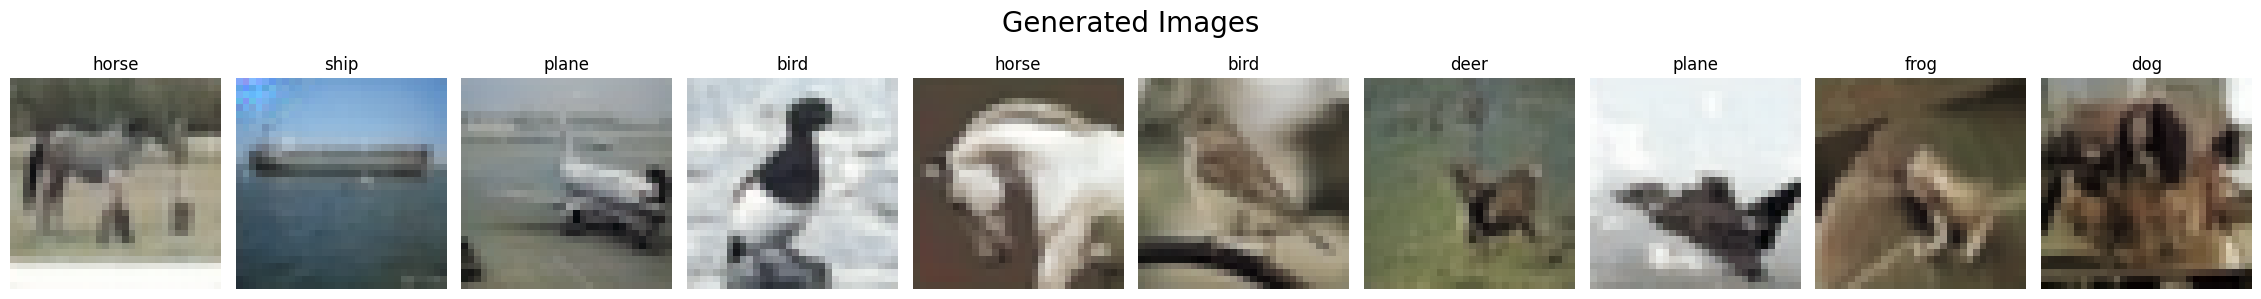

Batch 10


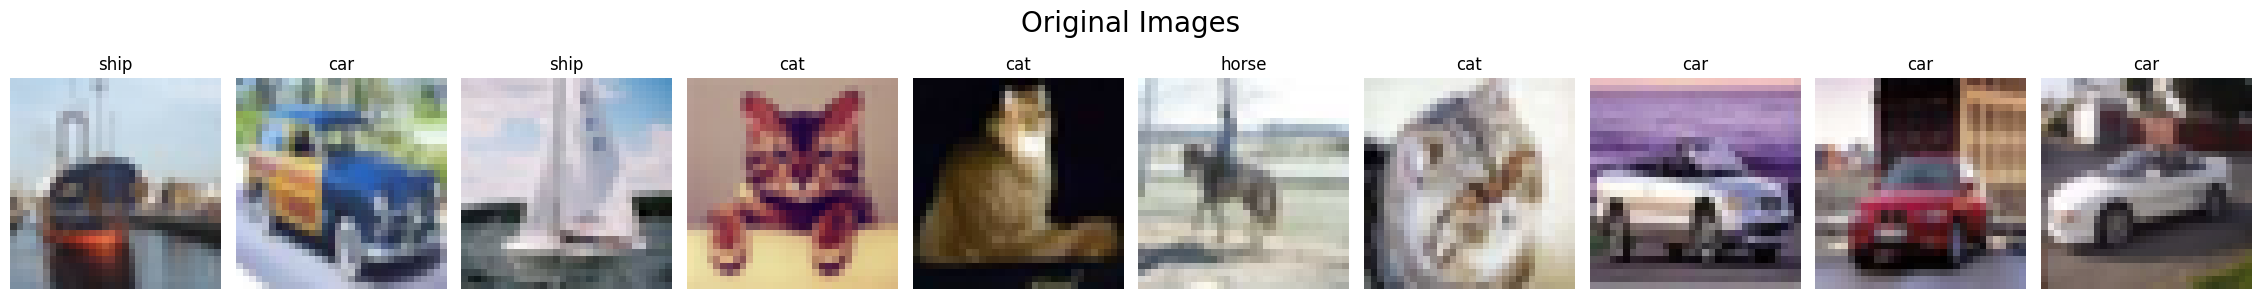

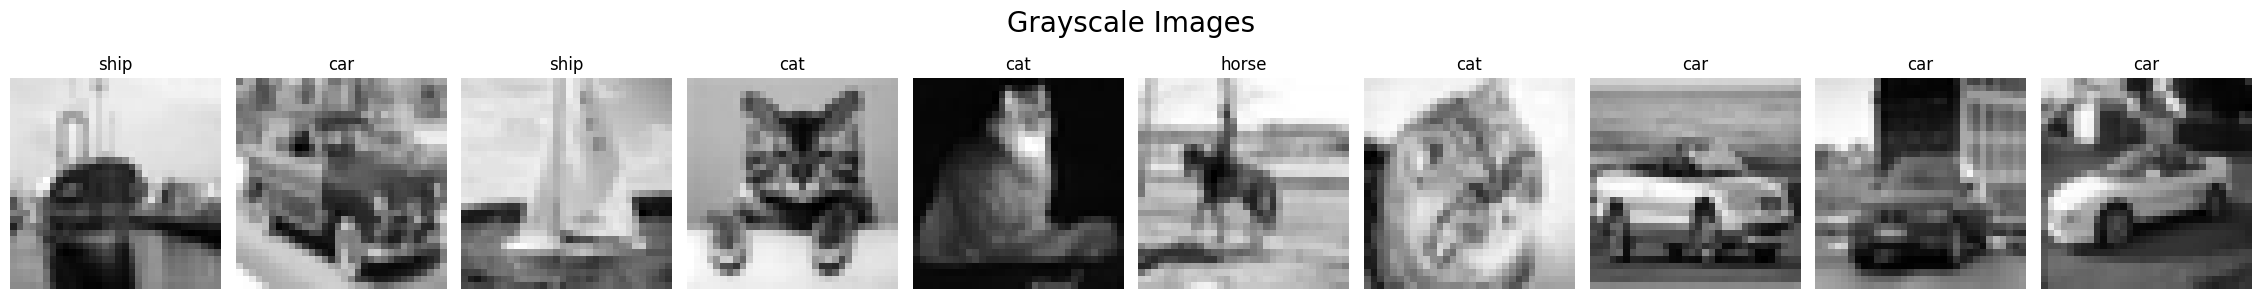

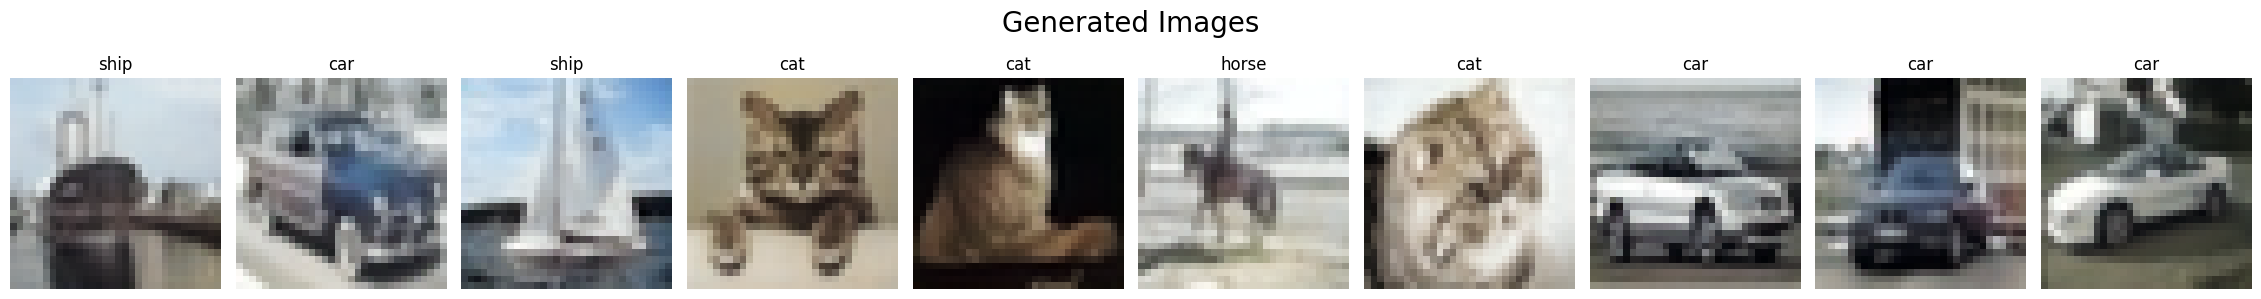

Batch 11


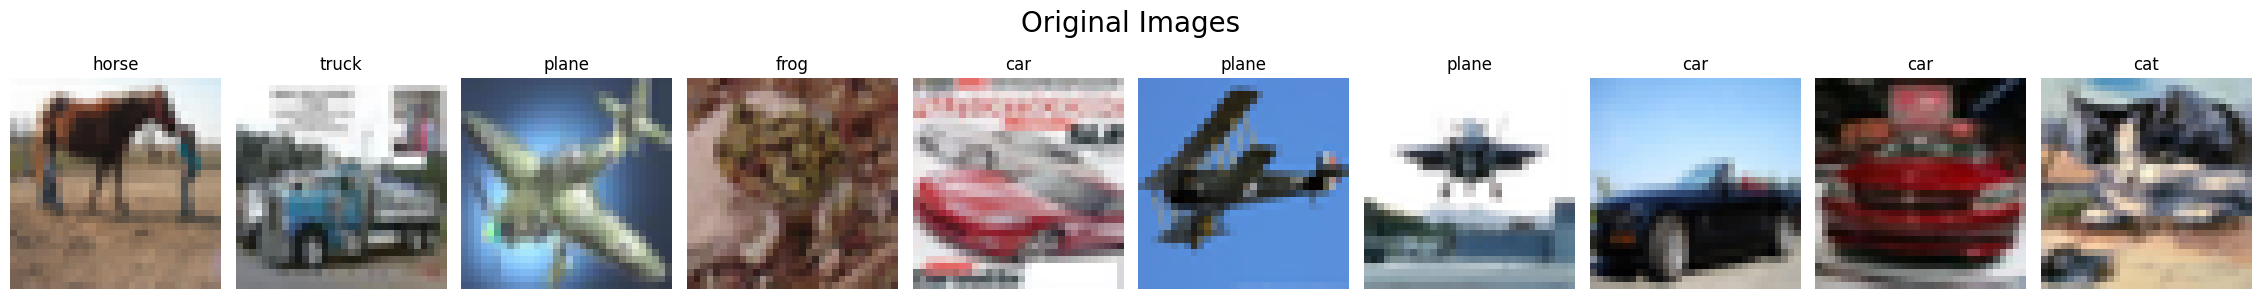

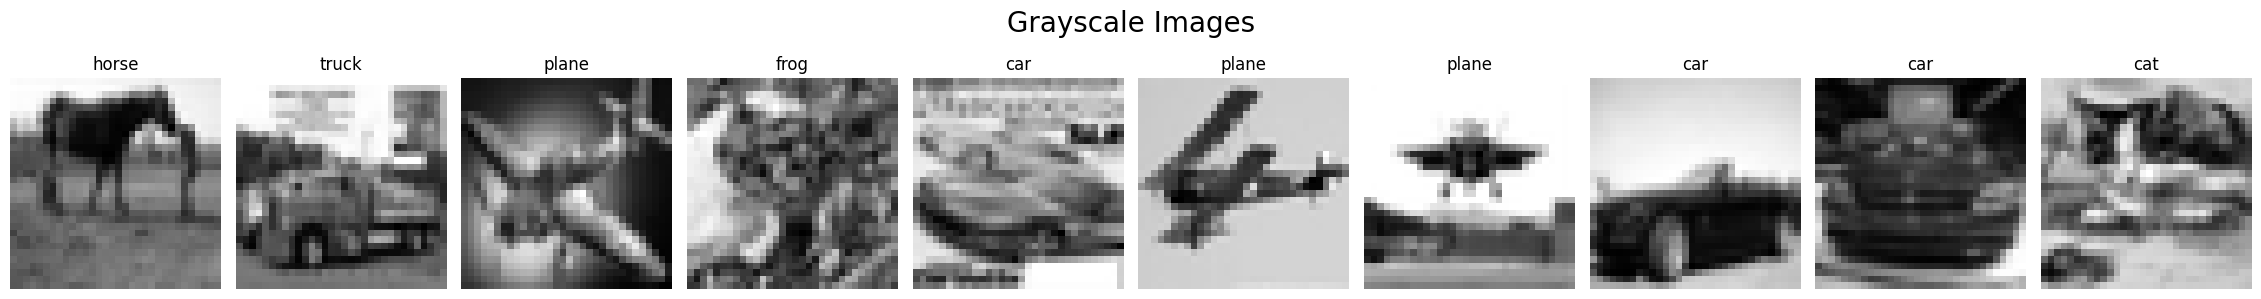

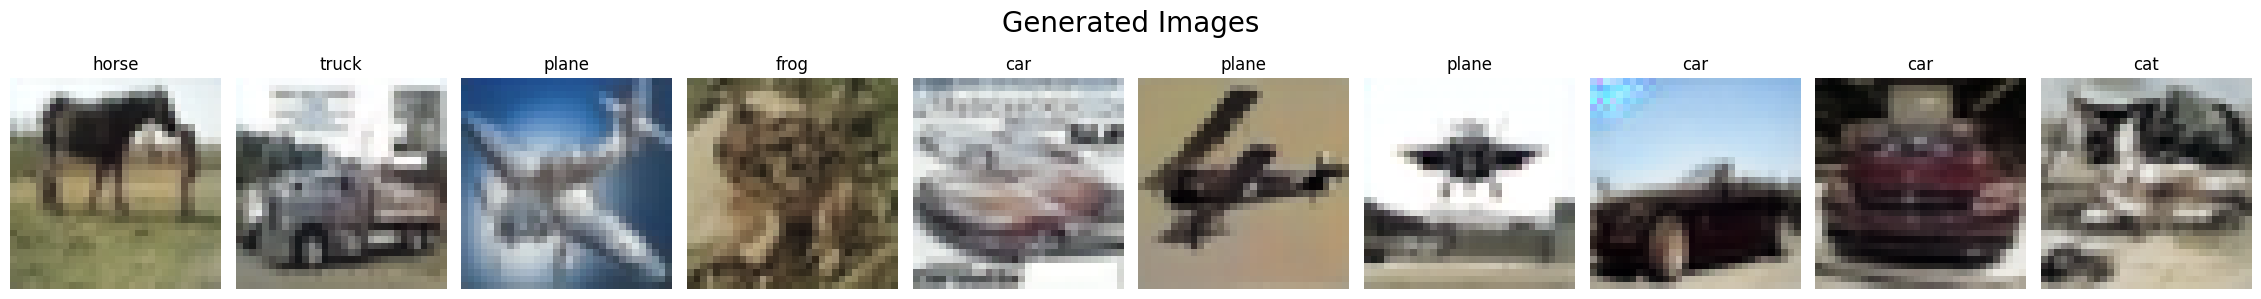

Test loss: 5.956263793632388e-05


In [138]:
test_AE(model, test_loader, loss_fn)